In [28]:
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import math
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import random
import tqdm

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [29]:
import matplotlib.pyplot as plt

class Island:
    def __init__(self, xcentr=5, ycentr=5, radius=1):
        self.xcentr = xcentr
        self.ycentr = ycentr
        self.radius = radius

    def belongs_to_boarder(self, x, y):
        dist = ((x - self.xcentr) ** 2 + (y - self.ycentr) ** 2) ** 0.5
        if dist <= self.radius:
            return True
        else:
            return False

    def get_dist(self, x, y):
        return ((x - self.xcentr) ** 2 + (y - self.ycentr) ** 2) ** 0.5 - self.radius

    def draw_island(self):
        return plt.Circle((self.xcentr, self.ycentr), self.radius)

    def getCoords(self):
        return [self.xcentr, self.ycentr]


In [30]:
x_lower_bound = 0
x_upper_bound = 10
y_lower_bound = 0
y_upper_bound = 10

a = {}

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [32]:
class Ship:
    def __init__(self, x = 1, y = 5, v = 1, direction = 0):
        self.x = x
        self.y = y
        self.v = v
        self.direction = direction
        self.positions = [[self.x, self.y]]
        self.cum_d = 0
        
    def move(self, dt=1):
        self.x += dt * self.v * math.cos(self.direction)
        self.y += dt * self.v * math.sin(self.direction)
        self.cum_d += self.direction
        
    def getCoords(self):
        return [self.x, self.y]
    
    def add_position(self):
        self.positions.append([self.x, self.y])
        
    def get_positions(self):
        return self.positions

In [85]:
class Environment(object):
    def __init__(self):
        super(Environment, self).__init__()
        self.action_space = ['left', 'right', 'idle']
        self.n_actions = len(self.action_space)
        self.n_features = 2

        self.build_environment()
        
        self.route = []
        self.list_of_route = []
        self.d = {}
        self.f = {}
        
        self.prev_dist = 0

        self.i = 0

        self.c = True

        self.longest = 0

        self.shortest = 0
        
    def get_state(self):
        a = self.ship.getCoords()
        b = self.island.getCoords()
        c = self.flag.getCoords()
        dxi, dyi = b[0] - a[0], b[1] - a[1]
        dxf, dyf = c[0] - a[0], c[1] - a[1]
        f_angle = math.atan2(dyf, dxf)
        x_f = 100 / (dxf ** 2 + dyf ** 2) * math.cos(f_angle)
        y_f = 100 / (dxf ** 2 + dyf ** 2) * math.sin(f_angle)
        return [f_angle - self.ship.direction, f_angle, dxf, dyf]

    def build_environment(self):
#         random.uniform(-15, 15), random.uniform(-15, 15)
        self.island = Island()
        self.flag = Island(random.uniform(-10, 10), random.uniform(-10, 10), 2)
        self.ship = Ship(random.uniform(-10, 10), random.uniform(-10, 10))
        a = self.ship.getCoords()
        c = self.flag.getCoords()
        dxf, dyf = c[0] - a[0], c[1] - a[1]
        f_angle = math.atan2(dyf, dxf)
        self.ship.direction = f_angle
        self.prev_dist = self.flag.get_dist(self.ship.x, self.ship.y)
    
    def reset(self):
        self.build_environment()
        self.d = {}
        self.i = 0
        return self.get_state()
    
    def step(self, action):
        dt = 1
        
        state = self.ship.getCoords()

        if action == 0:
            self.ship.direction += math.pi / 6
        elif action == 1:
            self.ship.direction -= math.pi / 6
        # elif action == 2:
        #     self.ship.v += 0.25
        # elif action == 3:
        #     self.ship.v -= 0.25
        
        # if self.ship.x < x_lower_bound:
        #     self.ship.x = x_lower_bound
        # if self.ship.y < y_lower_bound:
        #     self.ship.y = y_lower_bound
        # if self.ship.x > x_upper_bound:
        #     self.ship.x = x_upper_bound
        # if self.ship.y > y_lower_bound:
        #     self.ship.y = y_lower_bound
        
        self.ship.move(dt)
        
        self.ship.add_position()

        next_state = self.get_state()

        self.i += 1
        
        if self.flag.belongs_to_boarder(self.ship.x, self.ship.y):
            reward = 20000
            done = True
            
            self.d = {}
            self.i = 0

#         elif (self.island.belongs_to_boarder(next_state[0], next_state[1])):
#             reward = -1000
#             done = True

#             self.d = {}
#             self.i = 0
            
        elif len(self.ship.get_positions()) > 500:
            done = True
            self.d = {}
            self.i = 0
            # print("Time limit exceeded")
            reward = -1000 * (self.prev_dist - self.flag.get_dist(self.ship.x, self.ship.y)) ** 2

        else:
            reward = (self.prev_dist - self.flag.get_dist(self.ship.x, self.ship.y)) ** 3
            if reward < 0:
                reward *= 10
            # reward += 1 / (0.1 + self.ship.sum_d)
            done = False
        
        self.prev_dist = self.flag.get_dist(self.ship.x, self.ship.y)

        return next_state, reward, done 
    
    def draw_map(self):
        field, ax = plt.subplots()
        ax.set(xlim=(x_upper_bound * -2, x_upper_bound * 2), ylim=(y_upper_bound * -2, y_upper_bound * 2))
        ax.set_aspect(1)
        ax.add_artist(self.island.draw_island())
        ax.add_artist(self.flag.draw_island())
        pos = self.ship.get_positions()
        for i in range(len(pos) - 1):
            ax.plot([pos[i][0], pos[i + 1][0]], [pos[i][1], pos[i + 1][1]], marker = 'o', color='r')
        plt.show()

    def final(self):
        print('The shortest route:', self.shortest)
        print('The longest route:', self.longest)

def final_states():
    return a

if __name__ == '__main__':
    env = Environment()

Ключевая идея: подаем на вектор относительных координат острова и флага, а также пеленги на них.

In [86]:
BATCH_SIZE = 100
LR = 0.03
GAMMA = 0.90
EPSILON = 0.9
MEMORY_CAPACITY = 10000
Q_NETWORK_ITERATION = 1000

env = Environment()
NUM_ACTIONS = env.n_actions
NUM_STATES = 4
EPISODES = 2000

In [87]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(NUM_STATES, 60)
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2 = nn.Linear(60, NUM_ACTIONS)
        self.fc2.weight.data.normal_(0, 0.1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [88]:
class DQN():
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()
        self.memory = np.zeros((MEMORY_CAPACITY, NUM_STATES * 2 + 2))
        self.memory_counter = 0
        self.learn_counter = 0
        self.optimizer = optim.Adam(self.eval_net.parameters(), LR)
        self.loss = nn.MSELoss()
        
    def store_trans(self, state, action, reward, next_state):
        index = self.memory_counter % MEMORY_CAPACITY
        trans = np.hstack((state, action, reward, next_state))
        self.memory[index, :] = trans
        self.memory_counter += 1
        
    def choose_action(self, state):
        state = torch.unsqueeze(torch.FloatTensor(state), 0)
        if np.random.randn() <= EPSILON:
            action_value = self.eval_net.forward(state)
            action = torch.max(action_value, 1)[1].data.numpy()
            action = action[0]
        else:
            action = np.random.randint(0, NUM_ACTIONS)
        return action
    
    def learn(self):
        # learn 100 times then the target network update
        if self.learn_counter % Q_NETWORK_ITERATION == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_counter+=1

        sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
        batch_memory = self.memory[sample_index, :]
        batch_state = torch.FloatTensor(batch_memory[:, :NUM_STATES])
        #note that the action must be a int
        batch_action = torch.LongTensor(batch_memory[:, NUM_STATES:NUM_STATES+1].astype(int))
        batch_reward = torch.FloatTensor(batch_memory[:, NUM_STATES+1: NUM_STATES+2])
        batch_next_state = torch.FloatTensor(batch_memory[:, -NUM_STATES:])

        q_eval = self.eval_net(batch_state).gather(1, batch_action)
        q_next = self.target_net(batch_next_state).detach()
        q_target = batch_reward + GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)

        loss = self.loss(q_eval, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

The DQN is collecting experience...


  0%|                                                      | 0/2000 [00:00<?, ?it/s]

episode 0, the reward is 20000


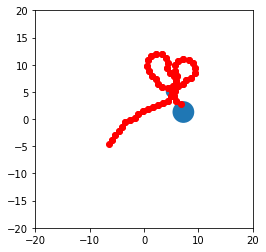

  0%|                                              | 1/2000 [00:00<03:43,  8.95it/s]

episode 1, the reward is 20000
episode 2, the reward is -748.66
episode 3, the reward is 20000


  0%|▏                                             | 6/2000 [00:00<01:16, 26.05it/s]

episode 4, the reward is -851.849
episode 5, the reward is -718.932
episode 6, the reward is 20000
episode 7, the reward is -346.081
episode 8, the reward is -967.093
episode 9, the reward is 20000
episode 10, the reward is 20000


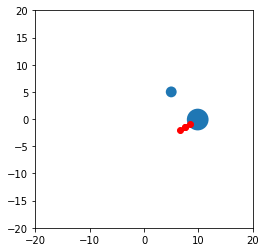

  1%|▎                                            | 16/2000 [00:00<01:02, 31.63it/s]

episode 11, the reward is -368.13
episode 12, the reward is 20000
episode 13, the reward is 20000
episode 14, the reward is -676.088
episode 15, the reward is -0.182
episode 16, the reward is -856.651
episode 17, the reward is -900.441


  1%|▍                                            | 20/2000 [00:00<01:04, 30.49it/s]

episode 18, the reward is 20000
episode 19, the reward is -450.627
episode 20, the reward is 20000


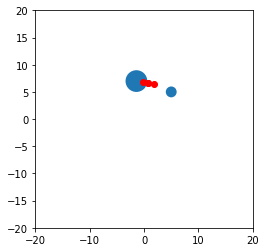

episode 21, the reward is 20000
episode 22, the reward is -890.035


  1%|▌                                            | 24/2000 [00:00<01:02, 31.79it/s]

episode 23, the reward is 20000


  1%|▋                                            | 28/2000 [00:00<01:04, 30.50it/s]

episode 24, the reward is -966.706
episode 25, the reward is -610.33
episode 26, the reward is 20000
episode 27, the reward is -78.614
episode 28, the reward is 20000
episode 29, the reward is -456.317
episode 30, the reward is -705.222


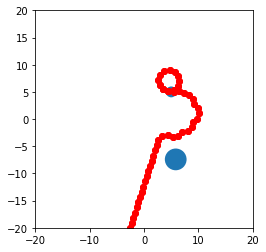

  2%|▋                                            | 32/2000 [00:01<02:09, 15.24it/s]

episode 31, the reward is 20000
episode 32, the reward is 20000
episode 33, the reward is 20000
episode 34, the reward is -314.295
episode 35, the reward is -89.493
episode 36, the reward is 20000


  2%|▊                                            | 38/2000 [00:01<01:51, 17.66it/s]

episode 37, the reward is -90.198
episode 38, the reward is -352.187
episode 39, the reward is 20000
episode 40, the reward is -951.09


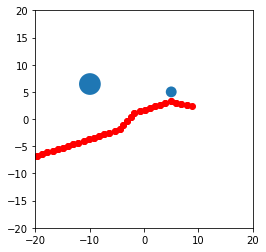

  2%|▉                                            | 43/2000 [00:03<04:16,  7.62it/s]

episode 41, the reward is 20000
episode 42, the reward is 20000
episode 43, the reward is 20000
episode 44, the reward is 20000


  2%|█                                            | 46/2000 [00:03<04:24,  7.39it/s]

episode 45, the reward is -326.999


  2%|█                                            | 48/2000 [00:03<04:24,  7.37it/s]

episode 46, the reward is 20000
episode 47, the reward is 20000


  2%|█▏                                           | 50/2000 [00:04<05:01,  6.47it/s]

episode 48, the reward is -846.586
episode 49, the reward is 20000
episode 50, the reward is 20000


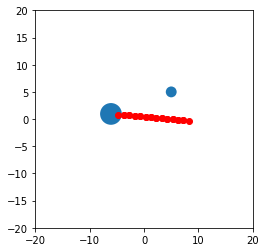

  3%|█▏                                           | 51/2000 [00:04<04:59,  6.50it/s]

episode 51, the reward is 20000
episode 52, the reward is 20000


  3%|█▏                                           | 54/2000 [00:04<04:57,  6.53it/s]

episode 53, the reward is -769.339


  3%|█▏                                           | 55/2000 [00:05<06:19,  5.13it/s]

episode 54, the reward is -688.291
episode 55, the reward is 20000


  3%|█▎                                           | 57/2000 [00:05<06:33,  4.93it/s]

episode 56, the reward is -785.739
episode 57, the reward is 20000


  3%|█▎                                           | 59/2000 [00:06<06:46,  4.78it/s]

episode 58, the reward is -41.388


  3%|█▎                                           | 60/2000 [00:06<08:01,  4.03it/s]

episode 59, the reward is -979.471
episode 60, the reward is 20000


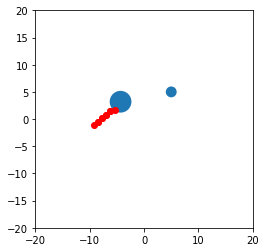

  3%|█▍                                           | 62/2000 [00:07<08:05,  3.99it/s]

episode 61, the reward is -591.991
episode 62, the reward is 20000
episode 63, the reward is 20000
episode 64, the reward is 20000


  3%|█▍                                           | 66/2000 [00:07<05:53,  5.47it/s]

episode 65, the reward is -861.394
episode 66, the reward is 20000
episode 67, the reward is 20000
episode 68, the reward is 20000
episode 69, the reward is 20000
episode 70, the reward is 20000


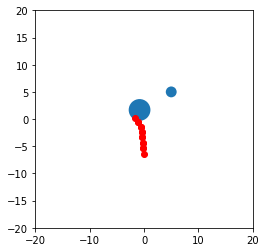

  4%|█▌                                           | 71/2000 [00:07<03:29,  9.23it/s]

episode 71, the reward is 20000


  4%|█▋                                           | 73/2000 [00:08<04:10,  7.70it/s]

episode 72, the reward is -79.247
episode 73, the reward is -549.049


  4%|█▋                                           | 75/2000 [00:09<06:20,  5.07it/s]

episode 74, the reward is -996.248
episode 75, the reward is 20000
episode 76, the reward is 20000
episode 77, the reward is 20000


  4%|█▊                                           | 79/2000 [00:09<04:33,  7.02it/s]

episode 78, the reward is 20000
episode 79, the reward is 20000
episode 80, the reward is -691.677


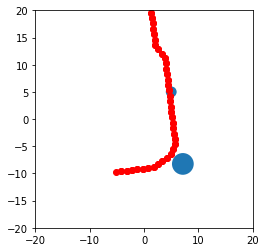

  4%|█▊                                           | 81/2000 [00:10<07:00,  4.56it/s]

episode 81, the reward is 20000
episode 82, the reward is 20000


  4%|█▉                                           | 84/2000 [00:10<06:14,  5.12it/s]

episode 83, the reward is -73.417


  4%|█▉                                           | 85/2000 [00:11<07:12,  4.43it/s]

episode 84, the reward is -197.851


  4%|█▉                                           | 86/2000 [00:11<07:14,  4.40it/s]

episode 85, the reward is 20000
episode 86, the reward is 20000


  4%|█▉                                           | 88/2000 [00:11<06:25,  4.96it/s]

episode 87, the reward is 20000


  4%|██                                           | 89/2000 [00:12<07:46,  4.10it/s]

episode 88, the reward is -21.207
episode 89, the reward is 20000
episode 90, the reward is -796.005


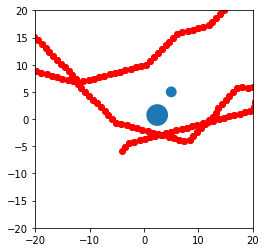

  5%|██                                           | 92/2000 [00:13<10:58,  2.90it/s]

episode 91, the reward is -786.552


  5%|██                                           | 93/2000 [00:13<11:27,  2.77it/s]

episode 92, the reward is -31.134
episode 93, the reward is 20000
episode 94, the reward is 20000


  5%|██▏                                          | 96/2000 [00:14<08:02,  3.94it/s]

episode 95, the reward is -40.088
episode 96, the reward is 20000


  5%|██▏                                          | 98/2000 [00:14<07:59,  3.97it/s]

episode 97, the reward is -681.07
episode 98, the reward is 20000
episode 99, the reward is 20000
episode 100, the reward is 20000


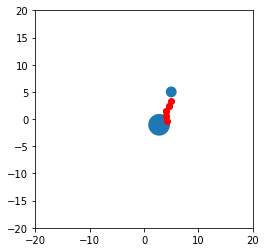

  5%|██▏                                         | 102/2000 [00:15<06:04,  5.20it/s]

episode 101, the reward is -27.611
episode 102, the reward is 20000
episode 103, the reward is 20000
episode 104, the reward is 20000
episode 105, the reward is 20000
episode 106, the reward is 20000


  5%|██▍                                         | 108/2000 [00:15<04:18,  7.32it/s]

episode 107, the reward is -262.358
episode 108, the reward is 20000
episode 109, the reward is 20000
episode 110, the reward is 20000


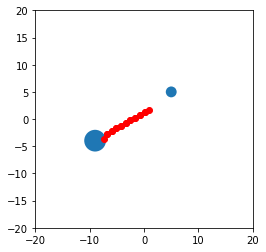

  6%|██▍                                         | 111/2000 [00:15<03:32,  8.90it/s]

episode 111, the reward is 20000
episode 112, the reward is 20000
episode 113, the reward is 20000
episode 114, the reward is 20000
episode 115, the reward is 20000


  6%|██▌                                         | 117/2000 [00:16<03:06, 10.09it/s]

episode 116, the reward is -417.917
episode 117, the reward is 20000
episode 118, the reward is 20000


  6%|██▋                                         | 120/2000 [00:16<03:29,  8.98it/s]

episode 119, the reward is -94.036
episode 120, the reward is 20000


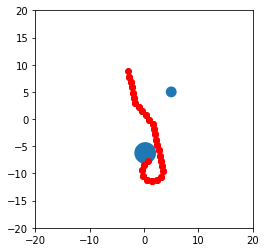

  6%|██▋                                         | 122/2000 [00:17<04:22,  7.15it/s]

episode 121, the reward is -297.516
episode 122, the reward is 20000


  6%|██▋                                         | 124/2000 [00:17<04:53,  6.40it/s]

episode 123, the reward is -321.202


  6%|██▊                                         | 125/2000 [00:18<05:57,  5.24it/s]

episode 124, the reward is -126.452
episode 125, the reward is 20000
episode 126, the reward is 20000


  6%|██▊                                         | 128/2000 [00:18<05:29,  5.68it/s]

episode 127, the reward is -14.224


  6%|██▊                                         | 129/2000 [00:19<06:41,  4.66it/s]

episode 128, the reward is -238.342


  6%|██▊                                         | 130/2000 [00:19<07:51,  3.96it/s]

episode 129, the reward is -373.501
episode 130, the reward is -196.462


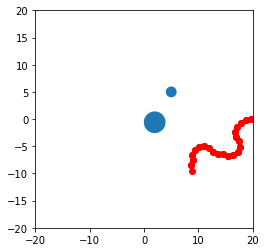

  7%|██▉                                         | 131/2000 [00:20<12:01,  2.59it/s]

episode 131, the reward is 20000
episode 132, the reward is 20000
episode 133, the reward is 20000
episode 134, the reward is 20000


  7%|██▉                                         | 136/2000 [00:21<06:42,  4.63it/s]

episode 135, the reward is -987.957


  7%|███                                         | 137/2000 [00:21<07:38,  4.07it/s]

episode 136, the reward is -54.667


  7%|███                                         | 138/2000 [00:21<08:34,  3.62it/s]

episode 137, the reward is -158.814
episode 138, the reward is 20000
episode 139, the reward is 20000
episode 140, the reward is 20000


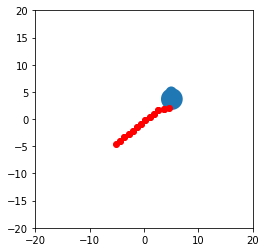

  7%|███                                         | 142/2000 [00:22<06:55,  4.47it/s]

episode 141, the reward is -61.467


  7%|███▏                                        | 143/2000 [00:22<08:05,  3.83it/s]

episode 142, the reward is -999.596
episode 143, the reward is 20000


  7%|███▏                                        | 145/2000 [00:23<08:05,  3.82it/s]

episode 144, the reward is -461.916


  7%|███▏                                        | 146/2000 [00:23<07:56,  3.89it/s]

episode 145, the reward is 20000
episode 146, the reward is 20000
episode 147, the reward is 20000
episode 148, the reward is 20000


  8%|███▎                                        | 150/2000 [00:24<05:46,  5.34it/s]

episode 149, the reward is -411.717
episode 150, the reward is 20000


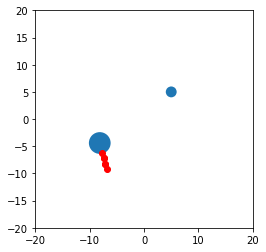

  8%|███▎                                        | 152/2000 [00:24<06:20,  4.85it/s]

episode 151, the reward is -31.068
episode 152, the reward is 20000
episode 153, the reward is 20000


  8%|███▍                                        | 155/2000 [00:25<05:37,  5.47it/s]

episode 154, the reward is -34.756


  8%|███▍                                        | 156/2000 [00:25<06:44,  4.55it/s]

episode 155, the reward is -809.131


  8%|███▍                                        | 157/2000 [00:25<07:54,  3.88it/s]

episode 156, the reward is -365.596
episode 157, the reward is 20000
episode 158, the reward is 20000
episode 159, the reward is 20000
episode 160, the reward is -990.01


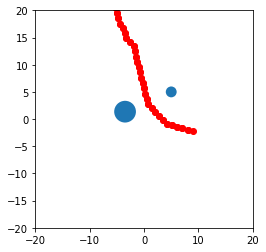

  8%|███▋                                        | 165/2000 [00:27<04:48,  6.35it/s]

episode 161, the reward is 20000
episode 162, the reward is 20000
episode 163, the reward is 20000
episode 164, the reward is 20000
episode 165, the reward is 20000
episode 166, the reward is 20000
episode 167, the reward is 20000


  8%|███▋                                        | 169/2000 [00:27<04:17,  7.11it/s]

episode 168, the reward is -853.23
episode 169, the reward is 20000
episode 170, the reward is -0.152


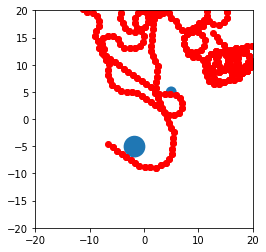

  9%|███▊                                        | 172/2000 [00:28<07:09,  4.25it/s]

episode 171, the reward is -438.123


  9%|███▊                                        | 173/2000 [00:29<08:07,  3.75it/s]

episode 172, the reward is -15.957
episode 173, the reward is 20000
episode 174, the reward is 20000
episode 175, the reward is 20000
episode 176, the reward is 20000
episode 177, the reward is 20000
episode 178, the reward is 20000


  9%|███▉                                        | 180/2000 [00:29<03:50,  7.88it/s]

episode 179, the reward is 20000
episode 180, the reward is -665.374


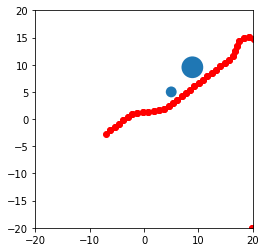

  9%|████                                        | 182/2000 [00:30<05:54,  5.13it/s]

episode 181, the reward is 20000


  9%|████                                        | 183/2000 [00:30<06:49,  4.43it/s]

episode 182, the reward is -347.372
episode 183, the reward is 20000
episode 184, the reward is 20000


  9%|████                                        | 186/2000 [00:31<05:57,  5.07it/s]

episode 185, the reward is -79.152
episode 186, the reward is 20000


  9%|████▏                                       | 188/2000 [00:31<06:02,  5.00it/s]

episode 187, the reward is -51.692


 10%|████▏                                       | 190/2000 [00:32<06:26,  4.69it/s]

episode 188, the reward is -677.53
episode 189, the reward is 20000
episode 190, the reward is -0.143


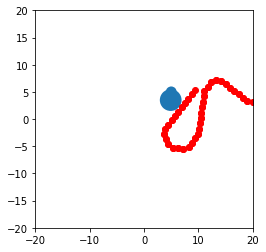

 10%|████▏                                       | 191/2000 [00:33<10:50,  2.78it/s]

episode 191, the reward is 20000


 10%|████▏                                       | 193/2000 [00:33<09:20,  3.22it/s]

episode 192, the reward is -61.116
episode 193, the reward is 20000
episode 194, the reward is 20000
episode 195, the reward is 20000


 10%|████▎                                       | 197/2000 [00:34<06:14,  4.81it/s]

episode 196, the reward is -982.68
episode 197, the reward is 20000


 10%|████▍                                       | 199/2000 [00:34<06:17,  4.78it/s]

episode 198, the reward is -398.739
episode 199, the reward is 20000
episode 200, the reward is -803.503


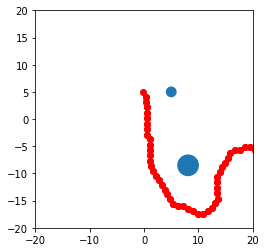

 10%|████▍                                       | 201/2000 [00:35<08:13,  3.64it/s]

episode 201, the reward is 20000
episode 202, the reward is 20000
episode 203, the reward is 20000
episode 204, the reward is 20000


 10%|████▌                                       | 206/2000 [00:35<05:28,  5.46it/s]

episode 205, the reward is -944.419
episode 206, the reward is 20000


 10%|████▌                                       | 208/2000 [00:36<05:38,  5.29it/s]

episode 207, the reward is -958.31


 10%|████▌                                       | 209/2000 [00:36<06:36,  4.51it/s]

episode 208, the reward is -953.166


 10%|████▌                                       | 210/2000 [00:37<07:34,  3.93it/s]

episode 209, the reward is -655.902
episode 210, the reward is 20000


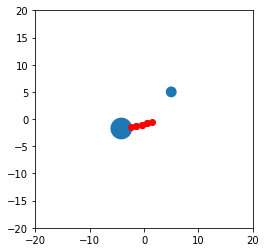

 11%|████▋                                       | 215/2000 [00:37<03:49,  7.77it/s]

episode 211, the reward is 20000
episode 212, the reward is 20000
episode 213, the reward is 20000
episode 214, the reward is 20000
episode 215, the reward is 20000
episode 216, the reward is 20000
episode 217, the reward is 20000


 11%|████▊                                       | 219/2000 [00:37<03:37,  8.18it/s]

episode 218, the reward is -830.33
episode 219, the reward is 20000
episode 220, the reward is -256.475


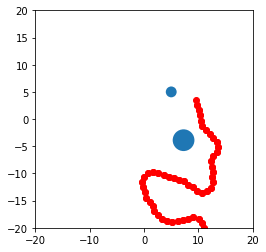

 11%|████▊                                       | 221/2000 [00:38<05:34,  5.31it/s]

episode 221, the reward is 20000


 11%|████▉                                       | 223/2000 [00:38<05:45,  5.15it/s]

episode 222, the reward is -779.956


 11%|████▉                                       | 224/2000 [00:39<06:48,  4.35it/s]

episode 223, the reward is -9.718
episode 224, the reward is 20000


 11%|████▉                                       | 226/2000 [00:39<06:47,  4.35it/s]

episode 225, the reward is -218.333


 11%|████▉                                       | 227/2000 [00:40<07:48,  3.79it/s]

episode 226, the reward is -671.136
episode 227, the reward is 20000


 11%|█████                                       | 229/2000 [00:40<07:24,  3.98it/s]

episode 228, the reward is -999.973
episode 229, the reward is 20000
episode 230, the reward is -897.191


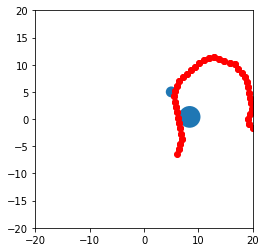

 12%|█████                                       | 231/2000 [00:41<09:18,  3.17it/s]

episode 231, the reward is 20000


 12%|█████▏                                      | 233/2000 [00:42<08:18,  3.54it/s]

episode 232, the reward is -144.783


 12%|█████▏                                      | 234/2000 [00:42<09:05,  3.24it/s]

episode 233, the reward is -55.383
episode 234, the reward is 20000
episode 235, the reward is 20000


 12%|█████▏                                      | 237/2000 [00:42<06:54,  4.26it/s]

episode 236, the reward is -0.762


 12%|█████▏                                      | 238/2000 [00:43<07:49,  3.75it/s]

episode 237, the reward is -815.903
episode 238, the reward is 20000
episode 239, the reward is 20000
episode 240, the reward is 20000


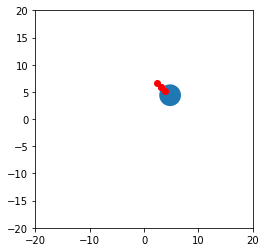

 12%|█████▎                                      | 243/2000 [00:43<03:56,  7.44it/s]

episode 241, the reward is 20000
episode 242, the reward is 20000
episode 243, the reward is 20000
episode 244, the reward is 20000


 12%|█████▍                                      | 246/2000 [00:43<03:58,  7.35it/s]

episode 245, the reward is -32.344
episode 246, the reward is 20000
episode 247, the reward is 20000
episode 248, the reward is 20000


 12%|█████▌                                      | 250/2000 [00:44<03:48,  7.66it/s]

episode 249, the reward is -944.281
episode 250, the reward is 20000


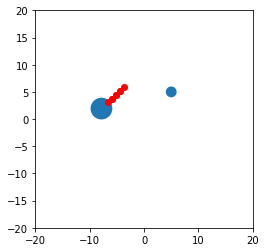

 13%|█████▌                                      | 254/2000 [00:44<02:58,  9.80it/s]

episode 251, the reward is 20000
episode 252, the reward is 20000
episode 253, the reward is 20000


 13%|█████▋                                      | 256/2000 [00:45<03:45,  7.73it/s]

episode 254, the reward is -3.158
episode 255, the reward is 20000
episode 256, the reward is 20000
episode 257, the reward is 20000
episode 258, the reward is 20000
episode 259, the reward is 20000
episode 260, the reward is 20000


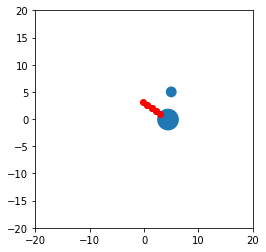

 13%|█████▋                                      | 261/2000 [00:45<02:28, 11.69it/s]

episode 261, the reward is 20000
episode 262, the reward is 20000
episode 263, the reward is 20000
episode 264, the reward is 20000


 13%|█████▊                                      | 266/2000 [00:45<02:36, 11.06it/s]

episode 265, the reward is -55.656


 13%|█████▉                                      | 268/2000 [00:46<03:17,  8.79it/s]

episode 266, the reward is 20000
episode 267, the reward is 20000
episode 268, the reward is 20000
episode 269, the reward is 20000
episode 270, the reward is 20000


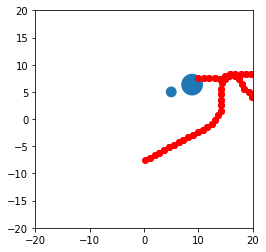

 14%|██████▏                                     | 280/2000 [00:46<02:11, 13.12it/s]

episode 271, the reward is -831.495
episode 272, the reward is 20000
episode 273, the reward is 20000
episode 274, the reward is 20000
episode 275, the reward is 20000
episode 276, the reward is 20000
episode 277, the reward is 20000
episode 278, the reward is 20000
episode 279, the reward is 20000
episode 280, the reward is 20000


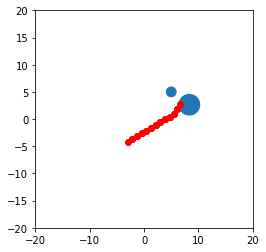

 14%|██████▏                                     | 282/2000 [00:47<02:35, 11.02it/s]

episode 281, the reward is 20000
episode 282, the reward is 20000
episode 283, the reward is 20000


 14%|██████▎                                     | 285/2000 [00:47<03:03,  9.35it/s]

episode 284, the reward is -900.014


 14%|██████▍                                     | 290/2000 [00:48<02:54,  9.77it/s]

episode 285, the reward is -735.061
episode 286, the reward is 20000
episode 287, the reward is 20000
episode 288, the reward is 20000
episode 289, the reward is 20000
episode 290, the reward is 20000


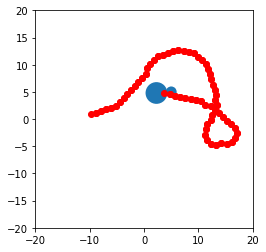

 15%|██████▍                                     | 292/2000 [00:48<03:04,  9.26it/s]

episode 291, the reward is 20000
episode 292, the reward is 20000


 15%|██████▍                                     | 294/2000 [00:49<04:13,  6.72it/s]

episode 293, the reward is -306.781
episode 294, the reward is 20000
episode 295, the reward is 20000
episode 296, the reward is 20000
episode 297, the reward is 20000


 15%|██████▌                                     | 299/2000 [00:49<02:49, 10.03it/s]

episode 298, the reward is 20000
episode 299, the reward is 20000
episode 300, the reward is 20000


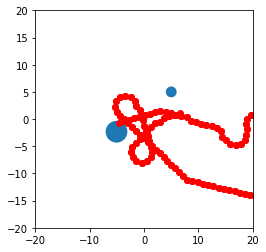

 15%|██████▌                                     | 301/2000 [00:50<05:25,  5.22it/s]

episode 301, the reward is 20000
episode 302, the reward is 20000
episode 303, the reward is 20000
episode 304, the reward is 20000
episode 305, the reward is 20000


 15%|██████▊                                     | 307/2000 [00:50<03:21,  8.40it/s]

episode 306, the reward is 20000


 15%|██████▊                                     | 309/2000 [00:51<03:48,  7.38it/s]

episode 307, the reward is -110.239
episode 308, the reward is 20000
episode 309, the reward is -579.529
episode 310, the reward is 20000


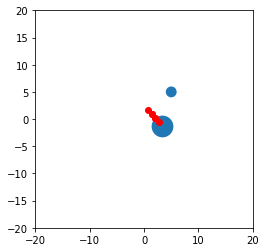

 16%|██████▊                                     | 312/2000 [00:51<05:27,  5.16it/s]

episode 311, the reward is -508.775
episode 312, the reward is 20000
episode 313, the reward is 20000
episode 314, the reward is 20000
episode 315, the reward is 20000
episode 316, the reward is 20000


 16%|██████▉                                     | 318/2000 [00:52<03:43,  7.54it/s]

episode 317, the reward is -895.642
episode 318, the reward is 20000
episode 319, the reward is 20000
episode 320, the reward is 20000


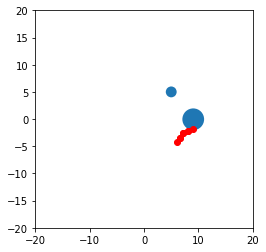

 16%|███████                                     | 321/2000 [00:52<02:59,  9.37it/s]

episode 321, the reward is 20000
episode 322, the reward is 20000
episode 323, the reward is 20000


 16%|███████▏                                    | 325/2000 [00:52<02:26, 11.45it/s]

episode 324, the reward is 20000


 16%|███████▏                                    | 328/2000 [00:52<02:03, 13.55it/s]

episode 325, the reward is 20000
episode 326, the reward is 20000
episode 327, the reward is 20000
episode 328, the reward is 20000
episode 329, the reward is 20000
episode 330, the reward is 20000


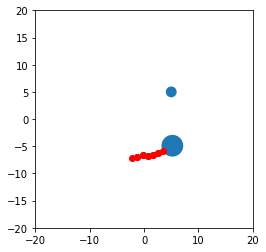

 17%|███████▎                                    | 331/2000 [00:53<01:51, 15.01it/s]

episode 331, the reward is 20000


 17%|███████▎                                    | 335/2000 [00:53<01:59, 13.91it/s]

episode 332, the reward is 20000
episode 333, the reward is 20000
episode 334, the reward is 20000
episode 335, the reward is 20000
episode 336, the reward is 20000


 17%|███████▍                                    | 338/2000 [00:53<02:11, 12.68it/s]

episode 337, the reward is 20000
episode 338, the reward is 20000


 17%|███████▍                                    | 340/2000 [00:54<03:05,  8.96it/s]

episode 339, the reward is -456.966
episode 340, the reward is 20000


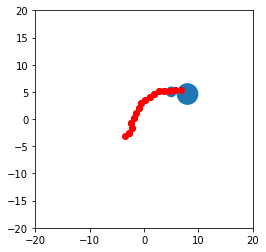

 17%|███████▌                                    | 342/2000 [00:54<02:39, 10.38it/s]

episode 341, the reward is 20000


 17%|███████▌                                    | 344/2000 [00:54<03:27,  7.99it/s]

episode 342, the reward is 20000
episode 343, the reward is 20000
episode 344, the reward is 20000


 17%|███████▌                                    | 346/2000 [00:54<03:57,  6.95it/s]

episode 345, the reward is 20000
episode 346, the reward is 20000
episode 347, the reward is 20000


 17%|███████▋                                    | 349/2000 [00:55<03:58,  6.92it/s]

episode 348, the reward is -262.195


 18%|███████▋                                    | 350/2000 [00:55<05:06,  5.39it/s]

episode 349, the reward is -911.552
episode 350, the reward is 20000


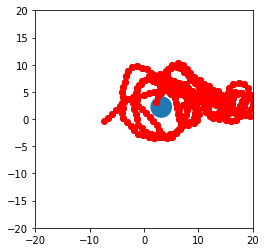

 18%|███████▋                                    | 351/2000 [00:56<07:01,  3.92it/s]

episode 351, the reward is 20000


 18%|███████▊                                    | 356/2000 [00:56<04:14,  6.45it/s]

episode 352, the reward is -565.333
episode 353, the reward is 20000
episode 354, the reward is 20000
episode 355, the reward is 20000
episode 356, the reward is 20000
episode 357, the reward is 20000


 18%|███████▉                                    | 359/2000 [00:57<03:54,  6.99it/s]

episode 358, the reward is 20000
episode 359, the reward is 20000
episode 360, the reward is 20000


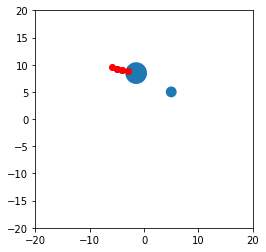

 18%|███████▉                                    | 361/2000 [00:57<03:20,  8.17it/s]

episode 361, the reward is 20000


 18%|███████▉                                    | 363/2000 [00:57<03:39,  7.47it/s]

episode 362, the reward is 20000
episode 363, the reward is 20000
episode 364, the reward is 20000
episode 365, the reward is 20000
episode 366, the reward is 20000
episode 367, the reward is 20000


 18%|████████                                    | 369/2000 [00:58<02:29, 10.88it/s]

episode 368, the reward is 20000
episode 369, the reward is 20000
episode 370, the reward is -824.255


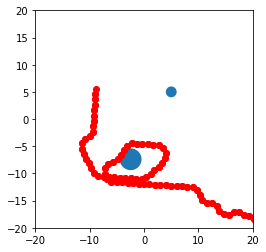

 19%|████████▏                                   | 372/2000 [00:59<04:14,  6.41it/s]

episode 371, the reward is 20000
episode 372, the reward is 20000


 19%|████████▎                                   | 380/2000 [00:59<02:11, 12.27it/s]

episode 373, the reward is 20000
episode 374, the reward is 20000
episode 375, the reward is 20000
episode 376, the reward is 20000
episode 377, the reward is 20000
episode 378, the reward is 20000
episode 379, the reward is 20000
episode 380, the reward is 20000


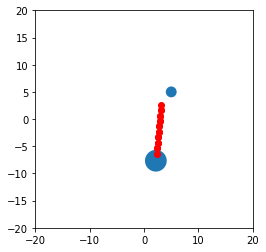

 19%|████████▍                                   | 384/2000 [00:59<01:55, 13.97it/s]

episode 381, the reward is 20000
episode 382, the reward is 20000
episode 383, the reward is 20000
episode 384, the reward is 20000


 19%|████████▌                                   | 387/2000 [00:59<01:47, 15.01it/s]

episode 385, the reward is 20000
episode 386, the reward is 20000
episode 387, the reward is 20000
episode 388, the reward is 20000


 20%|████████▌                                   | 390/2000 [01:00<02:26, 11.00it/s]

episode 389, the reward is -216.808
episode 390, the reward is 20000


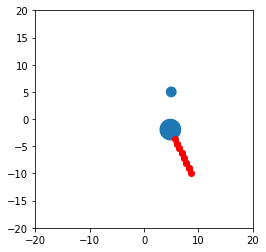

 20%|████████▌                                   | 392/2000 [01:00<02:26, 10.98it/s]

episode 391, the reward is 20000


 20%|████████▋                                   | 395/2000 [01:00<01:57, 13.63it/s]

episode 392, the reward is 20000
episode 393, the reward is 20000
episode 394, the reward is 20000


 20%|████████▊                                   | 399/2000 [01:01<02:43,  9.76it/s]

episode 395, the reward is -150.289
episode 396, the reward is 20000
episode 397, the reward is 20000
episode 398, the reward is 20000
episode 399, the reward is 20000
episode 400, the reward is 20000


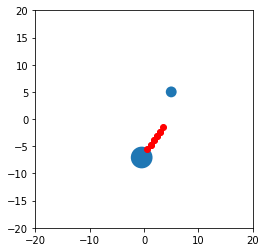

 20%|████████▊                                   | 401/2000 [01:01<02:32, 10.50it/s]

episode 401, the reward is 20000
episode 402, the reward is 20000


 20%|████████▉                                   | 407/2000 [01:01<02:09, 12.29it/s]

episode 403, the reward is 20000
episode 404, the reward is 20000
episode 405, the reward is 20000
episode 406, the reward is 20000
episode 407, the reward is 20000


 20%|████████▉                                   | 409/2000 [01:02<02:59,  8.85it/s]

episode 408, the reward is -1.565
episode 409, the reward is 20000
episode 410, the reward is 20000


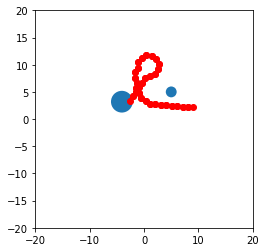

 21%|█████████                                   | 413/2000 [01:02<03:30,  7.53it/s]

episode 411, the reward is -906.527
episode 412, the reward is 20000
episode 413, the reward is 20000
episode 414, the reward is 20000
episode 415, the reward is 20000
episode 416, the reward is 20000


 21%|█████████▏                                  | 420/2000 [01:03<02:09, 12.23it/s]

episode 417, the reward is 20000
episode 418, the reward is 20000
episode 419, the reward is 20000
episode 420, the reward is 20000


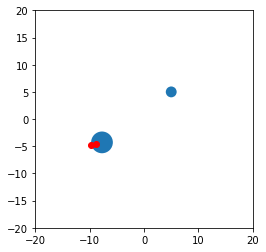

 21%|█████████▎                                  | 422/2000 [01:03<02:02, 12.88it/s]

episode 421, the reward is 20000
episode 422, the reward is 20000


 21%|█████████▎                                  | 424/2000 [01:03<02:56,  8.94it/s]

episode 423, the reward is -3.565


 21%|█████████▍                                  | 428/2000 [01:04<03:09,  8.30it/s]

episode 424, the reward is -16.809
episode 425, the reward is 20000
episode 426, the reward is 20000
episode 427, the reward is 20000
episode 428, the reward is 20000
episode 429, the reward is 20000
episode 430, the reward is 20000


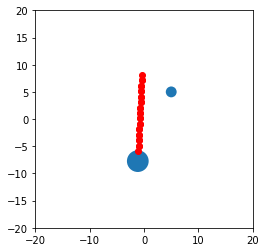

 22%|█████████▌                                  | 432/2000 [01:04<02:08, 12.23it/s]

episode 431, the reward is 20000
episode 432, the reward is 20000


 22%|█████████▌                                  | 436/2000 [01:04<02:15, 11.51it/s]

episode 433, the reward is 20000
episode 434, the reward is 20000
episode 435, the reward is 20000
episode 436, the reward is 20000


 22%|█████████▋                                  | 438/2000 [01:05<02:37,  9.93it/s]

episode 437, the reward is 20000
episode 438, the reward is 20000
episode 439, the reward is 20000
episode 440, the reward is -363.793


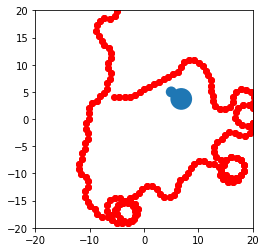

 22%|█████████▊                                  | 444/2000 [01:06<03:20,  7.75it/s]

episode 441, the reward is 20000
episode 442, the reward is 20000
episode 443, the reward is 20000
episode 444, the reward is 20000
episode 445, the reward is 20000
episode 446, the reward is 20000
episode 447, the reward is 20000
episode 448, the reward is 20000
episode 449, the reward is 20000
episode 450, the reward is 20000


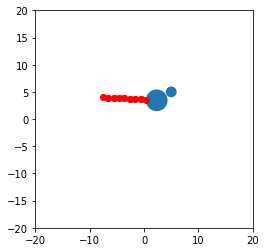

 23%|█████████▉                                  | 451/2000 [01:06<01:47, 14.36it/s]

episode 451, the reward is 20000
episode 452, the reward is 20000
episode 453, the reward is 20000
episode 454, the reward is 20000
episode 455, the reward is 20000


 23%|██████████                                  | 457/2000 [01:06<01:30, 17.10it/s]

episode 456, the reward is 20000
episode 457, the reward is 20000
episode 458, the reward is 20000
episode 459, the reward is 20000
episode 460, the reward is 20000


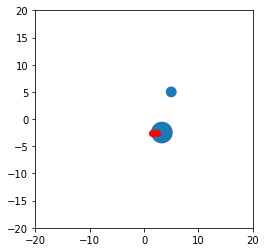

 23%|██████████▏                                 | 464/2000 [01:06<01:24, 18.20it/s]

episode 461, the reward is 20000
episode 462, the reward is 20000
episode 463, the reward is 20000
episode 464, the reward is 20000


 23%|██████████▎                                 | 467/2000 [01:07<01:36, 15.88it/s]

episode 465, the reward is 20000
episode 466, the reward is 20000
episode 467, the reward is 20000
episode 468, the reward is 20000


 24%|██████████▎                                 | 470/2000 [01:07<01:39, 15.33it/s]

episode 469, the reward is 20000
episode 470, the reward is 20000


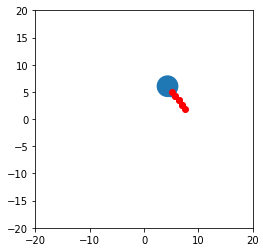

episode 471, the reward is 20000


 24%|██████████▌                                 | 478/2000 [01:07<01:30, 16.78it/s]

episode 472, the reward is 20000
episode 473, the reward is 20000
episode 474, the reward is 20000
episode 475, the reward is 20000
episode 476, the reward is 20000
episode 477, the reward is 20000
episode 478, the reward is 20000
episode 479, the reward is 20000
episode 480, the reward is 20000


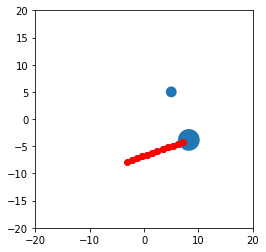

 24%|██████████▌                                 | 481/2000 [01:07<01:34, 16.02it/s]

episode 481, the reward is 20000
episode 482, the reward is 20000
episode 483, the reward is 20000
episode 484, the reward is 20000
episode 485, the reward is 20000


 24%|██████████▋                                 | 487/2000 [01:08<01:40, 15.12it/s]

episode 486, the reward is 20000
episode 487, the reward is 20000


 24%|██████████▊                                 | 489/2000 [01:08<02:21, 10.68it/s]

episode 488, the reward is -999.938
episode 489, the reward is -792.238
episode 490, the reward is 20000


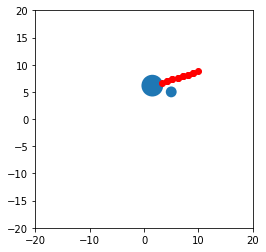

 25%|██████████▊                                 | 494/2000 [01:09<02:30, 10.00it/s]

episode 491, the reward is 20000
episode 492, the reward is 20000
episode 493, the reward is 20000
episode 494, the reward is 20000
episode 495, the reward is 20000
episode 496, the reward is 20000


 25%|██████████▉                                 | 498/2000 [01:09<02:16, 10.97it/s]

episode 497, the reward is 20000
episode 498, the reward is 20000
episode 499, the reward is 20000
episode 500, the reward is 20000


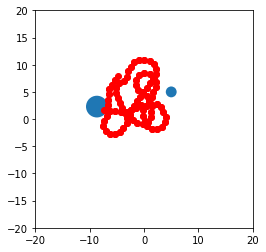

 25%|███████████                                 | 504/2000 [01:10<01:53, 13.16it/s]

episode 501, the reward is 20000
episode 502, the reward is 20000
episode 503, the reward is 20000
episode 504, the reward is 20000
episode 505, the reward is 20000


 25%|███████████▏                                | 507/2000 [01:10<02:31,  9.84it/s]

episode 506, the reward is -17.57
episode 507, the reward is 20000


 25%|███████████▏                                | 509/2000 [01:10<02:41,  9.23it/s]

episode 508, the reward is 20000
episode 509, the reward is 20000
episode 510, the reward is 20000


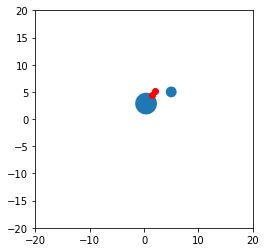

 26%|███████████▎                                | 512/2000 [01:11<03:09,  7.85it/s]

episode 511, the reward is -983.056
episode 512, the reward is 20000


 26%|███████████▎                                | 514/2000 [01:11<03:12,  7.73it/s]

episode 513, the reward is 20000
episode 514, the reward is 20000
episode 515, the reward is 20000


 26%|███████████▍                                | 518/2000 [01:12<03:33,  6.93it/s]

episode 516, the reward is -846.199
episode 517, the reward is 20000


 26%|███████████▍                                | 520/2000 [01:12<02:59,  8.27it/s]

episode 518, the reward is 20000
episode 519, the reward is 20000
episode 520, the reward is 20000


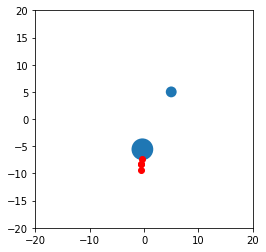

episode 521, the reward is 20000


 26%|███████████▋                                | 529/2000 [01:13<01:55, 12.73it/s]

episode 522, the reward is -843.627
episode 523, the reward is 20000
episode 524, the reward is 20000
episode 525, the reward is 20000
episode 526, the reward is 20000
episode 527, the reward is 20000
episode 528, the reward is 20000
episode 529, the reward is 20000
episode 530, the reward is 20000


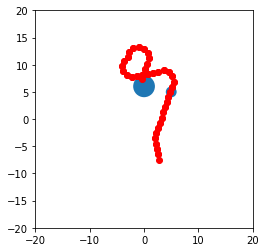

 27%|███████████▋                                | 533/2000 [01:13<02:08, 11.42it/s]

episode 531, the reward is 20000
episode 532, the reward is 20000
episode 533, the reward is 20000
episode 534, the reward is 20000
episode 535, the reward is 20000


 27%|███████████▊                                | 537/2000 [01:13<02:21, 10.36it/s]

episode 536, the reward is 20000


 27%|███████████▊                                | 539/2000 [01:14<02:48,  8.67it/s]

episode 537, the reward is 20000
episode 538, the reward is 20000
episode 539, the reward is 20000
episode 540, the reward is 20000


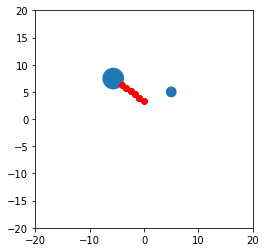

 27%|███████████▉                                | 542/2000 [01:14<03:01,  8.04it/s]

episode 541, the reward is 20000
episode 542, the reward is 20000


 27%|███████████▉                                | 544/2000 [01:15<03:45,  6.47it/s]

episode 543, the reward is -940.627
episode 544, the reward is 20000


 27%|████████████                                | 546/2000 [01:15<03:48,  6.35it/s]

episode 545, the reward is 20000


 27%|████████████                                | 547/2000 [01:15<04:55,  4.92it/s]

episode 546, the reward is -859.837
episode 547, the reward is 20000


 27%|████████████                                | 549/2000 [01:16<04:57,  4.88it/s]

episode 548, the reward is -187.597
episode 549, the reward is 20000
episode 550, the reward is 20000


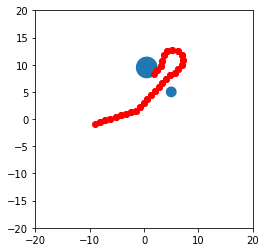

 28%|████████████▏                               | 556/2000 [01:16<02:24,  9.96it/s]

episode 551, the reward is 20000
episode 552, the reward is 20000
episode 553, the reward is 20000
episode 554, the reward is 20000
episode 555, the reward is 20000
episode 556, the reward is 20000
episode 557, the reward is 20000
episode 558, the reward is 20000
episode 559, the reward is 20000
episode 560, the reward is 20000


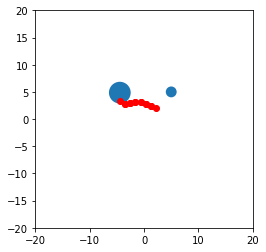

 28%|████████████▍                               | 563/2000 [01:17<01:21, 17.68it/s]

episode 561, the reward is 20000
episode 562, the reward is 20000
episode 563, the reward is 20000
episode 564, the reward is 20000


 28%|████████████▍                               | 566/2000 [01:17<01:15, 18.97it/s]

episode 565, the reward is 20000
episode 566, the reward is 20000
episode 567, the reward is 20000
episode 568, the reward is 20000
episode 569, the reward is 20000
episode 570, the reward is 20000


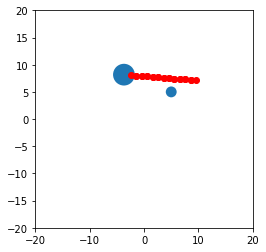

 29%|████████████▋                               | 577/2000 [01:17<01:05, 21.68it/s]

episode 571, the reward is 20000
episode 572, the reward is 20000
episode 573, the reward is 20000
episode 574, the reward is 20000
episode 575, the reward is 20000
episode 576, the reward is 20000
episode 577, the reward is 20000
episode 578, the reward is 20000
episode 579, the reward is 20000
episode 580, the reward is 20000


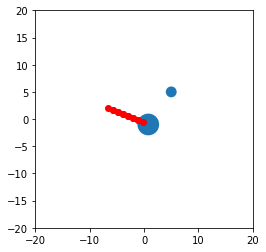

 29%|████████████▊                               | 581/2000 [01:17<01:02, 22.61it/s]

episode 581, the reward is 20000
episode 582, the reward is 20000


 29%|████████████▉                               | 588/2000 [01:17<00:50, 27.97it/s]

episode 583, the reward is 20000
episode 584, the reward is 20000
episode 585, the reward is 20000
episode 586, the reward is 20000
episode 587, the reward is 20000
episode 588, the reward is 20000
episode 589, the reward is 20000
episode 590, the reward is 20000


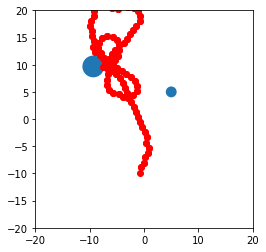

 30%|█████████████                               | 594/2000 [01:18<01:11, 19.62it/s]

episode 591, the reward is 20000
episode 592, the reward is 20000
episode 593, the reward is 20000
episode 594, the reward is 20000
episode 595, the reward is 20000
episode 596, the reward is 20000


 30%|█████████████▏                              | 598/2000 [01:18<01:18, 17.77it/s]

episode 597, the reward is 20000
episode 598, the reward is 20000
episode 599, the reward is 20000
episode 600, the reward is 20000


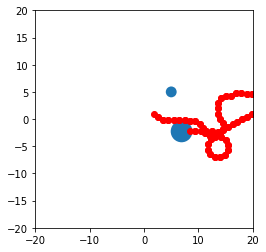

 30%|█████████████▏                              | 601/2000 [01:18<01:18, 17.75it/s]

episode 601, the reward is 20000
episode 602, the reward is 20000
episode 603, the reward is 20000


 30%|█████████████▍                              | 609/2000 [01:19<01:09, 20.02it/s]

episode 604, the reward is 20000
episode 605, the reward is 20000
episode 606, the reward is 20000
episode 607, the reward is 20000
episode 608, the reward is 20000
episode 609, the reward is 20000
episode 610, the reward is 20000


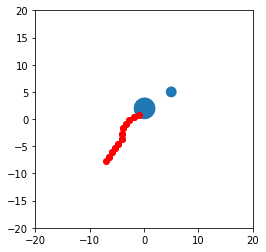

 31%|█████████████▌                              | 619/2000 [01:19<00:48, 28.50it/s]

episode 611, the reward is 20000
episode 612, the reward is 20000
episode 613, the reward is 20000
episode 614, the reward is 20000
episode 615, the reward is 20000
episode 616, the reward is 20000
episode 617, the reward is 20000
episode 618, the reward is 20000
episode 619, the reward is 20000
episode 620, the reward is 20000


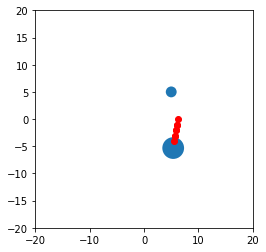

 31%|█████████████▋                              | 623/2000 [01:19<01:01, 22.39it/s]

episode 621, the reward is 20000
episode 622, the reward is 20000
episode 623, the reward is 20000


 31%|█████████████▊                              | 629/2000 [01:19<00:48, 28.46it/s]

episode 624, the reward is 20000
episode 625, the reward is 20000
episode 626, the reward is 20000
episode 627, the reward is 20000
episode 628, the reward is 20000
episode 629, the reward is 20000
episode 630, the reward is 20000


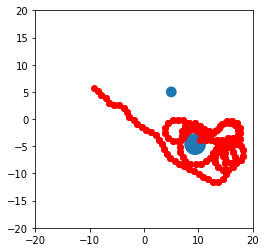

 32%|█████████████▉                              | 633/2000 [01:20<01:41, 13.47it/s]

episode 631, the reward is -140.271
episode 632, the reward is 20000
episode 633, the reward is 20000
episode 634, the reward is 20000
episode 635, the reward is 20000
episode 636, the reward is 20000
episode 637, the reward is 20000
episode 638, the reward is 20000
episode 639, the reward is 20000
episode 640, the reward is 20000


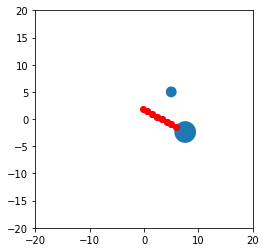

 32%|██████████████▎                             | 650/2000 [01:21<00:57, 23.32it/s]

episode 641, the reward is 20000
episode 642, the reward is 20000
episode 643, the reward is 20000
episode 644, the reward is 20000
episode 645, the reward is 20000
episode 646, the reward is 20000
episode 647, the reward is 20000
episode 648, the reward is 20000
episode 649, the reward is 20000
episode 650, the reward is 20000


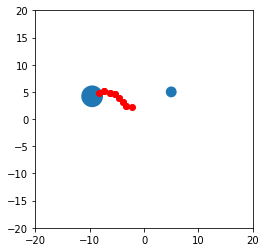

 33%|██████████████▍                             | 654/2000 [01:21<00:52, 25.85it/s]

episode 651, the reward is 20000
episode 652, the reward is 20000
episode 653, the reward is 20000
episode 654, the reward is 20000
episode 655, the reward is 20000
episode 656, the reward is 20000
episode 657, the reward is 20000
episode 658, the reward is 20000
episode 659, the reward is 20000
episode 660, the reward is 20000


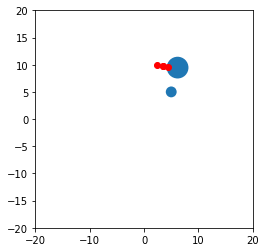

 33%|██████████████▋                             | 667/2000 [01:21<00:42, 31.65it/s]

episode 661, the reward is 20000
episode 662, the reward is 20000
episode 663, the reward is 20000
episode 664, the reward is 20000
episode 665, the reward is 20000
episode 666, the reward is 20000
episode 667, the reward is 20000
episode 668, the reward is 20000
episode 669, the reward is 20000
episode 670, the reward is 20000


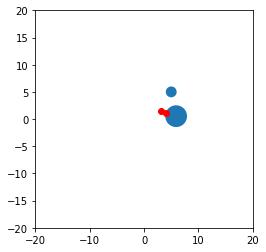

 34%|██████████████▉                             | 678/2000 [01:21<00:36, 35.77it/s]

episode 671, the reward is 20000
episode 672, the reward is 20000
episode 673, the reward is 20000
episode 674, the reward is 20000
episode 675, the reward is 20000
episode 676, the reward is 20000
episode 677, the reward is 20000
episode 678, the reward is 20000
episode 679, the reward is 20000
episode 680, the reward is 20000


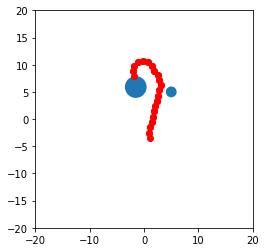

 34%|███████████████                             | 686/2000 [01:22<00:44, 29.82it/s]

episode 681, the reward is 20000
episode 682, the reward is 20000
episode 683, the reward is 20000
episode 684, the reward is 20000
episode 685, the reward is 20000
episode 686, the reward is 20000
episode 687, the reward is 20000
episode 688, the reward is 20000
episode 689, the reward is 20000
episode 690, the reward is 20000


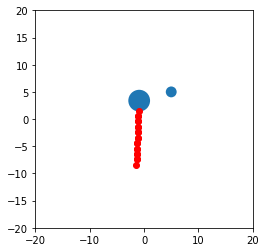

 35%|███████████████▏                            | 691/2000 [01:22<00:40, 32.47it/s]

episode 691, the reward is 20000
episode 692, the reward is 20000


 35%|███████████████▎                            | 695/2000 [01:22<00:41, 31.76it/s]

episode 693, the reward is 20000
episode 694, the reward is 20000
episode 695, the reward is 20000


 35%|███████████████▍                            | 700/2000 [01:22<00:38, 33.80it/s]

episode 696, the reward is 20000
episode 697, the reward is 20000
episode 698, the reward is 20000
episode 699, the reward is 20000
episode 700, the reward is -989.711


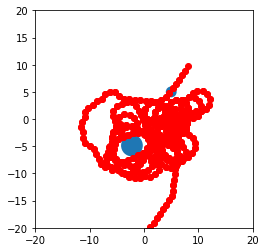

episode 701, the reward is 20000


 35%|███████████████▍                            | 704/2000 [01:23<02:30,  8.58it/s]

episode 702, the reward is -900.378
episode 703, the reward is 20000
episode 704, the reward is 20000
episode 705, the reward is 20000
episode 706, the reward is 20000
episode 707, the reward is 20000
episode 708, the reward is 20000
episode 709, the reward is 20000
episode 710, the reward is 20000


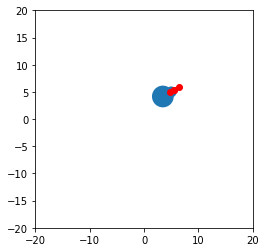

 36%|███████████████▋                            | 715/2000 [01:24<01:24, 15.18it/s]

episode 711, the reward is 20000
episode 712, the reward is 20000
episode 713, the reward is 20000
episode 714, the reward is 20000
episode 715, the reward is 20000
episode 716, the reward is 20000


 36%|███████████████▊                            | 719/2000 [01:24<01:11, 17.86it/s]

episode 717, the reward is 20000
episode 718, the reward is 20000
episode 719, the reward is 20000
episode 720, the reward is 20000


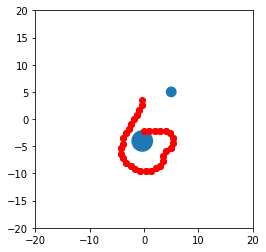

 36%|███████████████▉                            | 723/2000 [01:24<01:09, 18.50it/s]

episode 721, the reward is 20000
episode 722, the reward is 20000
episode 723, the reward is 20000


 36%|███████████████▉                            | 726/2000 [01:24<01:28, 14.33it/s]

episode 724, the reward is 20000
episode 725, the reward is 20000
episode 726, the reward is 20000
episode 727, the reward is 20000
episode 728, the reward is 20000
episode 729, the reward is 20000
episode 730, the reward is 20000


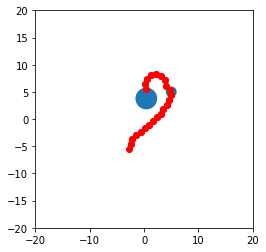

 37%|████████████████▎                           | 740/2000 [01:25<00:48, 26.17it/s]

episode 731, the reward is 20000
episode 732, the reward is 20000
episode 733, the reward is 20000
episode 734, the reward is 20000
episode 735, the reward is 20000
episode 736, the reward is 20000
episode 737, the reward is 20000
episode 738, the reward is 20000
episode 739, the reward is 20000
episode 740, the reward is 20000


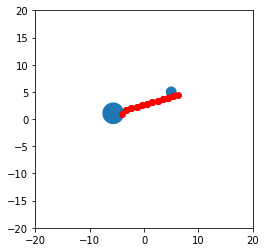

 37%|████████████████▍                           | 745/2000 [01:25<00:42, 29.56it/s]

episode 741, the reward is 20000
episode 742, the reward is 20000
episode 743, the reward is 20000
episode 744, the reward is 20000
episode 745, the reward is 20000
episode 746, the reward is 20000
episode 747, the reward is 20000
episode 748, the reward is 20000
episode 749, the reward is 20000
episode 750, the reward is 20000


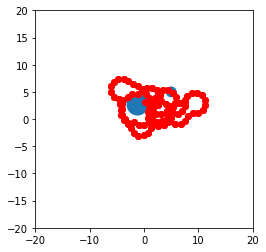

 38%|████████████████▌                           | 751/2000 [01:25<00:50, 24.58it/s]

episode 751, the reward is 20000
episode 752, the reward is 20000
episode 753, the reward is 20000
episode 754, the reward is 20000
episode 755, the reward is 20000
episode 756, the reward is 20000
episode 757, the reward is 20000
episode 758, the reward is 20000
episode 759, the reward is 20000
episode 760, the reward is 20000


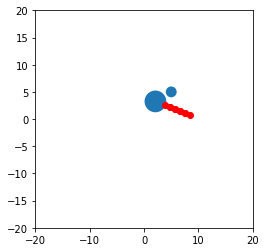

 38%|████████████████▊                           | 766/2000 [01:25<00:35, 34.66it/s]

episode 761, the reward is 20000
episode 762, the reward is 20000
episode 763, the reward is 20000
episode 764, the reward is 20000
episode 765, the reward is 20000
episode 766, the reward is 20000
episode 767, the reward is 20000
episode 768, the reward is 20000
episode 769, the reward is 20000
episode 770, the reward is 20000


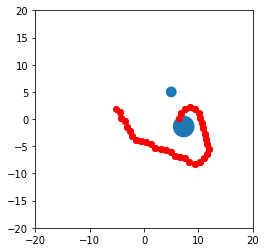

 39%|████████████████▉                           | 771/2000 [01:26<00:37, 32.44it/s]

episode 771, the reward is 20000
episode 772, the reward is 20000
episode 773, the reward is 20000
episode 774, the reward is 20000
episode 775, the reward is 20000
episode 776, the reward is 20000
episode 777, the reward is 20000
episode 778, the reward is 20000
episode 779, the reward is 20000
episode 780, the reward is 20000


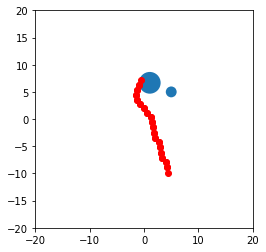

 39%|█████████████████▏                          | 781/2000 [01:26<00:30, 39.50it/s]

episode 781, the reward is 20000


 39%|█████████████████▎                          | 787/2000 [01:26<00:29, 40.72it/s]

episode 782, the reward is 20000
episode 783, the reward is 20000
episode 784, the reward is 20000
episode 785, the reward is 20000
episode 786, the reward is 20000
episode 787, the reward is 20000
episode 788, the reward is 20000
episode 789, the reward is 20000
episode 790, the reward is 20000


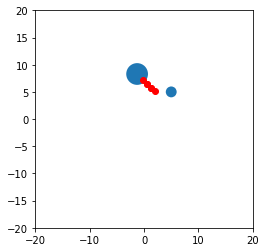

 40%|█████████████████▌                          | 797/2000 [01:26<00:30, 39.89it/s]

episode 791, the reward is 20000
episode 792, the reward is 20000
episode 793, the reward is 20000
episode 794, the reward is 20000
episode 795, the reward is 20000
episode 796, the reward is 20000
episode 797, the reward is 20000
episode 798, the reward is 20000
episode 799, the reward is 20000
episode 800, the reward is 20000


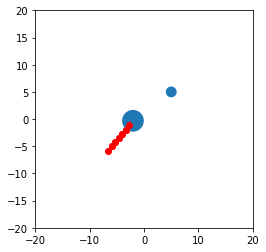

 40%|█████████████████▋                          | 802/2000 [01:26<00:32, 37.40it/s]

episode 801, the reward is 20000
episode 802, the reward is 20000
episode 803, the reward is 20000
episode 804, the reward is 20000


 40%|█████████████████▋                          | 806/2000 [01:26<00:34, 34.70it/s]

episode 805, the reward is 20000
episode 806, the reward is 20000
episode 807, the reward is 20000
episode 808, the reward is 20000
episode 809, the reward is 20000
episode 810, the reward is 20000


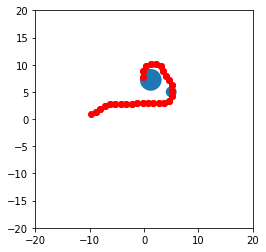

 41%|█████████████████▊                          | 811/2000 [01:27<00:39, 30.39it/s]

episode 811, the reward is 20000
episode 812, the reward is 20000
episode 813, the reward is 20000
episode 814, the reward is 20000
episode 815, the reward is 20000


 41%|█████████████████▉                          | 817/2000 [01:27<00:35, 32.96it/s]

episode 816, the reward is 20000
episode 817, the reward is 20000
episode 818, the reward is 20000
episode 819, the reward is 20000
episode 820, the reward is 20000


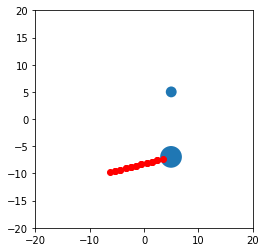

 41%|██████████████████                          | 821/2000 [01:27<00:39, 29.80it/s]

episode 821, the reward is 20000
episode 822, the reward is 20000
episode 823, the reward is 20000
episode 824, the reward is 20000
episode 825, the reward is 20000
episode 826, the reward is 20000


 41%|██████████████████▏                         | 828/2000 [01:27<00:43, 27.09it/s]

episode 827, the reward is 20000
episode 828, the reward is 20000
episode 829, the reward is 20000
episode 830, the reward is 20000


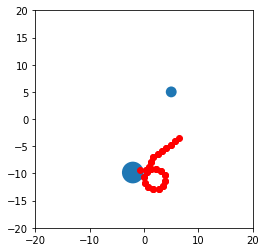

 42%|██████████████████▎                         | 831/2000 [01:27<00:46, 24.90it/s]

episode 831, the reward is 20000


 42%|██████████████████▍                         | 837/2000 [01:28<00:37, 31.25it/s]

episode 832, the reward is 20000
episode 833, the reward is 20000
episode 834, the reward is 20000
episode 835, the reward is 20000
episode 836, the reward is 20000
episode 837, the reward is 20000
episode 838, the reward is 20000
episode 839, the reward is 20000
episode 840, the reward is 20000


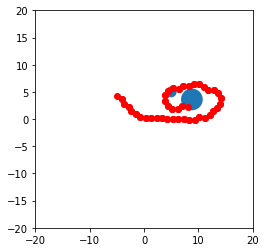

 42%|██████████████████▌                         | 841/2000 [01:28<00:38, 29.93it/s]

episode 841, the reward is 20000
episode 842, the reward is 20000
episode 843, the reward is 20000
episode 844, the reward is 20000
episode 845, the reward is 20000
episode 846, the reward is 20000
episode 847, the reward is 20000
episode 848, the reward is 20000
episode 849, the reward is 20000
episode 850, the reward is 20000


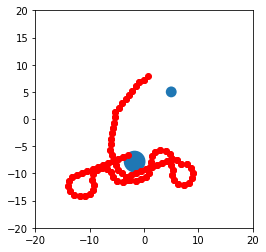

 43%|██████████████████▉                         | 858/2000 [01:28<00:30, 37.87it/s]

episode 851, the reward is 20000
episode 852, the reward is 20000
episode 853, the reward is 20000
episode 854, the reward is 20000
episode 855, the reward is 20000
episode 856, the reward is 20000
episode 857, the reward is 20000
episode 858, the reward is 20000
episode 859, the reward is 20000
episode 860, the reward is 20000


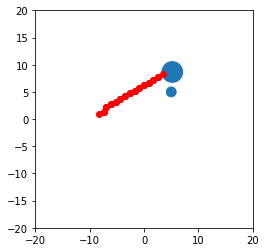

 43%|███████████████████                         | 869/2000 [01:28<00:28, 39.18it/s]

episode 861, the reward is 20000
episode 862, the reward is 20000
episode 863, the reward is 20000
episode 864, the reward is 20000
episode 865, the reward is 20000
episode 866, the reward is 20000
episode 867, the reward is 20000
episode 868, the reward is 20000
episode 869, the reward is 20000
episode 870, the reward is 20000


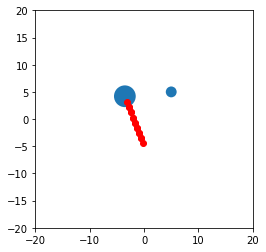

 44%|███████████████████▏                        | 874/2000 [01:29<00:29, 38.47it/s]

episode 871, the reward is 20000
episode 872, the reward is 20000
episode 873, the reward is 20000
episode 874, the reward is 20000
episode 875, the reward is 20000
episode 876, the reward is 20000
episode 877, the reward is 20000
episode 878, the reward is 20000
episode 879, the reward is 20000
episode 880, the reward is 20000


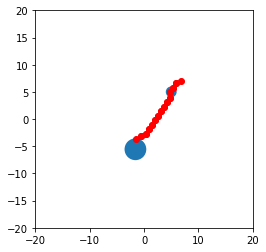

 44%|███████████████████▍                        | 881/2000 [01:29<00:27, 41.13it/s]

episode 881, the reward is 20000


 44%|███████████████████▌                        | 888/2000 [01:29<00:23, 47.09it/s]

episode 882, the reward is 20000
episode 883, the reward is 20000
episode 884, the reward is 20000
episode 885, the reward is 20000
episode 886, the reward is 20000
episode 887, the reward is 20000
episode 888, the reward is 20000
episode 889, the reward is 20000
episode 890, the reward is 20000


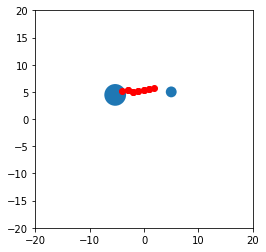

 45%|███████████████████▊                        | 900/2000 [01:29<00:25, 43.35it/s]

episode 891, the reward is 20000
episode 892, the reward is 20000
episode 893, the reward is 20000
episode 894, the reward is 20000
episode 895, the reward is 20000
episode 896, the reward is 20000
episode 897, the reward is 20000
episode 898, the reward is 20000
episode 899, the reward is 20000
episode 900, the reward is 20000


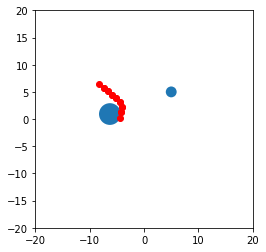

 46%|████████████████████                        | 910/2000 [01:29<00:25, 42.98it/s]

episode 901, the reward is 20000
episode 902, the reward is 20000
episode 903, the reward is 20000
episode 904, the reward is 20000
episode 905, the reward is 20000
episode 906, the reward is 20000
episode 907, the reward is 20000
episode 908, the reward is 20000
episode 909, the reward is 20000
episode 910, the reward is 20000


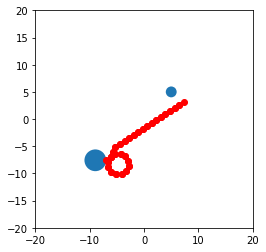

 46%|████████████████████▏                       | 915/2000 [01:30<00:32, 33.85it/s]

episode 911, the reward is 20000
episode 912, the reward is 20000
episode 913, the reward is 20000
episode 914, the reward is 20000
episode 915, the reward is 20000
episode 916, the reward is 20000
episode 917, the reward is 20000
episode 918, the reward is 20000
episode 919, the reward is 20000
episode 920, the reward is 20000


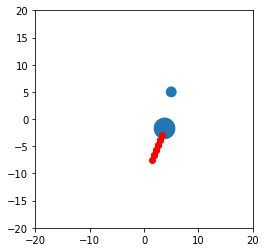

 46%|████████████████████▍                       | 930/2000 [01:30<00:24, 43.61it/s]

episode 921, the reward is 20000
episode 922, the reward is 20000
episode 923, the reward is 20000
episode 924, the reward is 20000
episode 925, the reward is 20000
episode 926, the reward is 20000
episode 927, the reward is 20000
episode 928, the reward is 20000
episode 929, the reward is 20000
episode 930, the reward is 20000


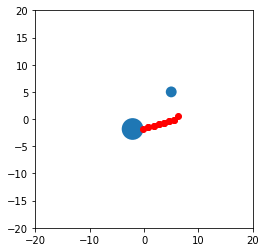

 47%|████████████████████▌                       | 935/2000 [01:30<00:26, 40.58it/s]

episode 931, the reward is 20000
episode 932, the reward is 20000
episode 933, the reward is 20000
episode 934, the reward is 20000
episode 935, the reward is 20000
episode 936, the reward is 20000
episode 937, the reward is 20000
episode 938, the reward is 20000
episode 939, the reward is 20000
episode 940, the reward is 20000


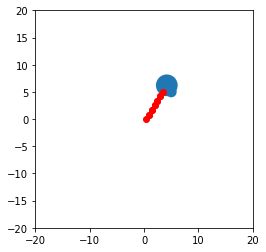

 47%|████████████████████▊                       | 946/2000 [01:30<00:25, 41.23it/s]

episode 941, the reward is 20000
episode 942, the reward is 20000
episode 943, the reward is 20000
episode 944, the reward is 20000
episode 945, the reward is 20000
episode 946, the reward is 20000
episode 947, the reward is 20000
episode 948, the reward is 20000
episode 949, the reward is 20000
episode 950, the reward is 20000


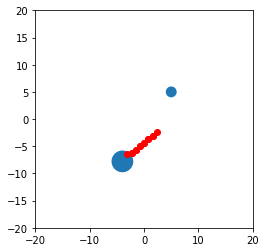

 48%|█████████████████████                       | 958/2000 [01:31<00:25, 41.09it/s]

episode 951, the reward is 20000
episode 952, the reward is 20000
episode 953, the reward is 20000
episode 954, the reward is 20000
episode 955, the reward is 20000
episode 956, the reward is 20000
episode 957, the reward is 20000
episode 958, the reward is 20000
episode 959, the reward is 20000
episode 960, the reward is 20000


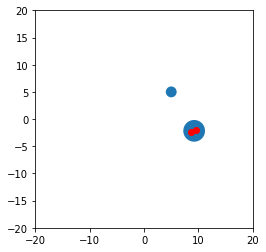

 48%|█████████████████████▏                      | 963/2000 [01:31<00:27, 37.37it/s]

episode 961, the reward is 20000
episode 962, the reward is 20000
episode 963, the reward is 20000
episode 964, the reward is 20000
episode 965, the reward is 20000
episode 966, the reward is 20000


 48%|█████████████████████▎                      | 970/2000 [01:31<00:23, 44.19it/s]

episode 967, the reward is 20000
episode 968, the reward is 20000
episode 969, the reward is 20000
episode 970, the reward is 20000


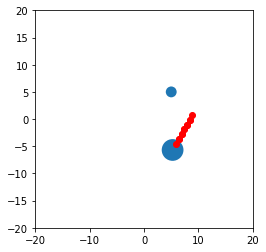

episode 971, the reward is 20000
episode 972, the reward is 20000
episode 973, the reward is 20000


 49%|█████████████████████▍                      | 975/2000 [01:31<00:30, 33.34it/s]

episode 974, the reward is 20000
episode 975, the reward is 20000


 49%|█████████████████████▌                      | 980/2000 [01:31<00:29, 34.68it/s]

episode 976, the reward is 20000
episode 977, the reward is 20000
episode 978, the reward is 20000
episode 979, the reward is 20000
episode 980, the reward is 20000


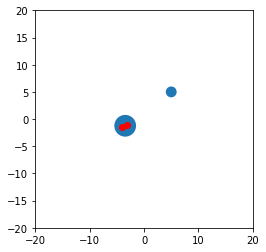

 49%|█████████████████████▋                      | 984/2000 [01:31<00:28, 35.75it/s]

episode 981, the reward is 20000
episode 982, the reward is 20000
episode 983, the reward is 20000
episode 984, the reward is 20000
episode 985, the reward is 20000
episode 986, the reward is 20000
episode 987, the reward is 20000
episode 988, the reward is 20000
episode 989, the reward is 20000
episode 990, the reward is 20000


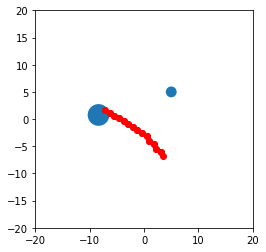

 50%|█████████████████████▉                      | 996/2000 [01:32<00:45, 22.14it/s]

episode 991, the reward is -249.622
episode 992, the reward is 20000
episode 993, the reward is 20000
episode 994, the reward is 20000
episode 995, the reward is 20000
episode 996, the reward is 20000
episode 997, the reward is 20000


 50%|█████████████████████▌                     | 1000/2000 [01:32<01:02, 16.08it/s]

episode 998, the reward is -581.098
episode 999, the reward is 20000
episode 1000, the reward is 20000


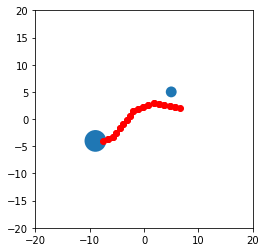

 50%|█████████████████████▌                     | 1003/2000 [01:33<00:56, 17.55it/s]

episode 1001, the reward is 20000
episode 1002, the reward is 20000
episode 1003, the reward is 20000
episode 1004, the reward is 20000
episode 1005, the reward is 20000
episode 1006, the reward is 20000
episode 1007, the reward is 20000
episode 1008, the reward is 20000
episode 1009, the reward is 20000
episode 1010, the reward is 20000


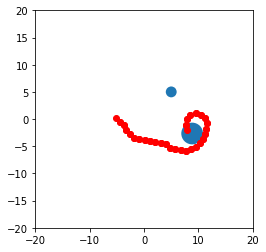

 51%|█████████████████████▋                     | 1011/2000 [01:33<00:39, 25.23it/s]

episode 1011, the reward is 20000
episode 1012, the reward is 20000
episode 1013, the reward is 20000
episode 1014, the reward is 20000
episode 1015, the reward is 20000
episode 1016, the reward is 20000


 51%|█████████████████████▉                     | 1019/2000 [01:33<00:30, 32.65it/s]

episode 1017, the reward is 20000
episode 1018, the reward is 20000
episode 1019, the reward is 20000
episode 1020, the reward is 20000


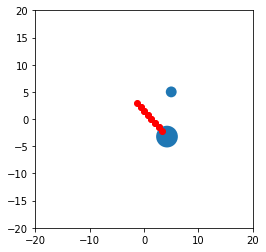

 51%|██████████████████████                     | 1024/2000 [01:33<00:30, 31.62it/s]

episode 1021, the reward is 20000
episode 1022, the reward is 20000
episode 1023, the reward is 20000
episode 1024, the reward is 20000
episode 1025, the reward is 20000
episode 1026, the reward is 20000
episode 1027, the reward is 20000
episode 1028, the reward is 20000


 52%|██████████████████████▏                    | 1030/2000 [01:33<00:45, 21.12it/s]

episode 1029, the reward is -707.095
episode 1030, the reward is 20000


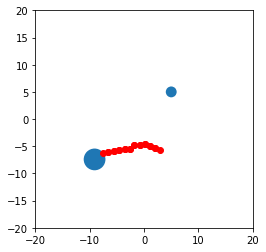

 52%|██████████████████████▏                    | 1034/2000 [01:34<00:41, 23.29it/s]

episode 1031, the reward is 20000
episode 1032, the reward is 20000
episode 1033, the reward is 20000
episode 1034, the reward is 20000
episode 1035, the reward is 20000
episode 1036, the reward is 20000
episode 1037, the reward is 20000
episode 1038, the reward is 20000
episode 1039, the reward is 20000
episode 1040, the reward is 20000


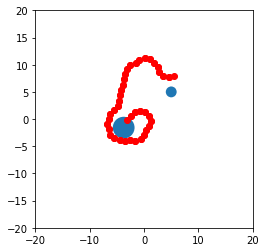

 52%|██████████████████████▌                    | 1047/2000 [01:34<00:33, 28.52it/s]

episode 1041, the reward is 20000
episode 1042, the reward is 20000
episode 1043, the reward is 20000
episode 1044, the reward is 20000
episode 1045, the reward is 20000
episode 1046, the reward is 20000
episode 1047, the reward is 20000
episode 1048, the reward is 20000
episode 1049, the reward is 20000
episode 1050, the reward is 20000


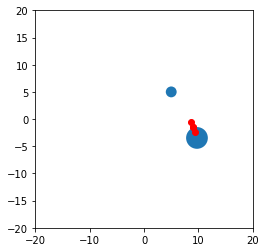

 53%|██████████████████████▌                    | 1051/2000 [01:34<00:31, 30.45it/s]

episode 1051, the reward is 20000


 53%|██████████████████████▋                    | 1056/2000 [01:34<00:27, 34.12it/s]

episode 1052, the reward is 20000
episode 1053, the reward is 20000
episode 1054, the reward is 20000
episode 1055, the reward is 20000
episode 1056, the reward is 20000
episode 1057, the reward is 20000
episode 1058, the reward is 20000
episode 1059, the reward is 20000
episode 1060, the reward is 20000


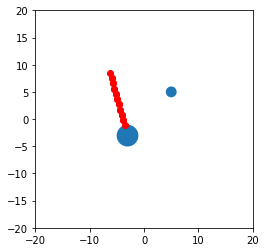

 53%|██████████████████████▊                    | 1061/2000 [01:34<00:30, 30.39it/s]

episode 1061, the reward is 20000
episode 1062, the reward is 20000
episode 1063, the reward is 20000
episode 1064, the reward is 20000


 53%|██████████████████████▉                    | 1067/2000 [01:35<00:26, 35.38it/s]

episode 1065, the reward is 20000
episode 1066, the reward is 20000
episode 1067, the reward is -629.829
episode 1068, the reward is 20000
episode 1069, the reward is 20000
episode 1070, the reward is 20000


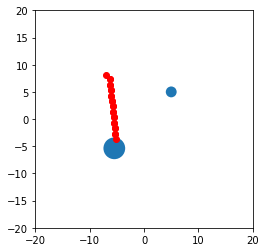

 54%|███████████████████████                    | 1072/2000 [01:35<00:52, 17.64it/s]

episode 1071, the reward is 20000


 54%|███████████████████████▏                   | 1076/2000 [01:35<00:47, 19.38it/s]

episode 1072, the reward is 20000
episode 1073, the reward is 20000
episode 1074, the reward is 20000
episode 1075, the reward is 20000
episode 1076, the reward is 20000
episode 1077, the reward is 20000
episode 1078, the reward is 20000
episode 1079, the reward is 20000
episode 1080, the reward is 20000


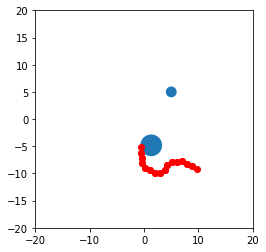

 54%|███████████████████████▏                   | 1081/2000 [01:35<00:42, 21.87it/s]

episode 1081, the reward is 20000
episode 1082, the reward is 20000


 54%|███████████████████████▎                   | 1085/2000 [01:36<00:37, 24.27it/s]

episode 1083, the reward is 20000
episode 1084, the reward is 20000
episode 1085, the reward is 20000
episode 1086, the reward is 20000
episode 1087, the reward is 20000
episode 1088, the reward is 20000
episode 1089, the reward is 20000
episode 1090, the reward is 20000


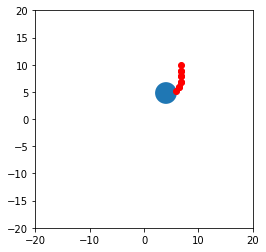

 55%|███████████████████████▍                   | 1091/2000 [01:36<00:30, 29.37it/s]

episode 1091, the reward is 20000
episode 1092, the reward is 20000


 55%|███████████████████████▌                   | 1098/2000 [01:36<00:24, 36.97it/s]

episode 1093, the reward is 20000
episode 1094, the reward is 20000
episode 1095, the reward is 20000
episode 1096, the reward is 20000
episode 1097, the reward is 20000
episode 1098, the reward is 20000
episode 1099, the reward is 20000
episode 1100, the reward is 20000


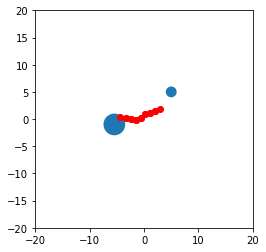

episode 1101, the reward is 20000


 55%|███████████████████████▋                   | 1103/2000 [01:36<00:26, 33.91it/s]

episode 1102, the reward is 20000
episode 1103, the reward is 20000
episode 1104, the reward is 20000
episode 1105, the reward is 20000
episode 1106, the reward is 20000
episode 1107, the reward is 20000
episode 1108, the reward is 20000


 56%|███████████████████████▊                   | 1110/2000 [01:36<00:34, 25.61it/s]

episode 1109, the reward is 20000
episode 1110, the reward is 20000


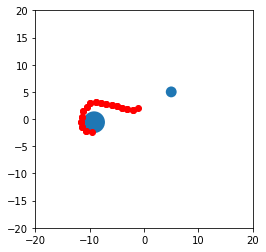

 56%|███████████████████████▉                   | 1114/2000 [01:37<00:32, 26.86it/s]

episode 1111, the reward is 20000
episode 1112, the reward is 20000
episode 1113, the reward is 20000
episode 1114, the reward is 20000


 56%|████████████████████████                   | 1118/2000 [01:37<00:46, 19.01it/s]

episode 1115, the reward is 20000
episode 1116, the reward is 20000
episode 1117, the reward is 20000
episode 1118, the reward is 20000
episode 1119, the reward is 20000
episode 1120, the reward is 20000


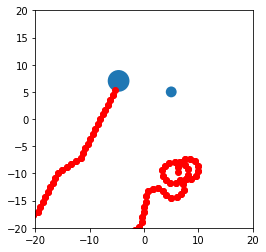

 56%|████████████████████████                   | 1121/2000 [01:38<01:22, 10.69it/s]

episode 1121, the reward is 20000
episode 1122, the reward is 20000
episode 1123, the reward is 20000
episode 1124, the reward is 20000
episode 1125, the reward is 20000


 56%|████████████████████████▏                  | 1127/2000 [01:38<01:02, 13.98it/s]

episode 1126, the reward is 20000
episode 1127, the reward is 20000
episode 1128, the reward is 20000


 56%|████████████████████████▎                  | 1130/2000 [01:38<01:19, 10.90it/s]

episode 1129, the reward is -147.061
episode 1130, the reward is 20000


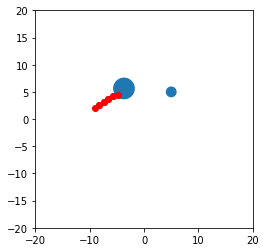

 57%|████████████████████████▍                  | 1136/2000 [01:38<00:55, 15.52it/s]

episode 1131, the reward is 20000
episode 1132, the reward is 20000
episode 1133, the reward is 20000
episode 1134, the reward is 20000
episode 1135, the reward is 20000
episode 1136, the reward is 20000
episode 1137, the reward is 20000
episode 1138, the reward is 20000
episode 1139, the reward is 20000
episode 1140, the reward is 20000


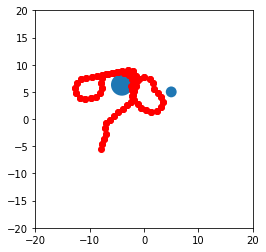

 57%|████████████████████████▌                  | 1144/2000 [01:39<00:47, 18.11it/s]

episode 1141, the reward is 20000
episode 1142, the reward is 20000
episode 1143, the reward is 20000
episode 1144, the reward is 20000
episode 1145, the reward is 20000
episode 1146, the reward is 20000
episode 1147, the reward is 20000
episode 1148, the reward is 20000
episode 1149, the reward is 20000
episode 1150, the reward is 20000


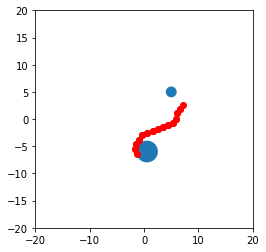

 58%|████████████████████████▉                  | 1160/2000 [01:39<00:28, 29.69it/s]

episode 1151, the reward is 20000
episode 1152, the reward is 20000
episode 1153, the reward is 20000
episode 1154, the reward is 20000
episode 1155, the reward is 20000
episode 1156, the reward is 20000
episode 1157, the reward is 20000
episode 1158, the reward is 20000
episode 1159, the reward is 20000
episode 1160, the reward is 20000


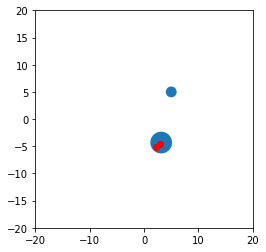

episode 1161, the reward is 20000
episode 1162, the reward is 20000


 58%|█████████████████████████                  | 1164/2000 [01:40<00:43, 19.24it/s]

episode 1163, the reward is 20000
episode 1164, the reward is 20000
episode 1165, the reward is 20000
episode 1166, the reward is 20000
episode 1167, the reward is 20000
episode 1168, the reward is 20000
episode 1169, the reward is 20000
episode 1170, the reward is 20000


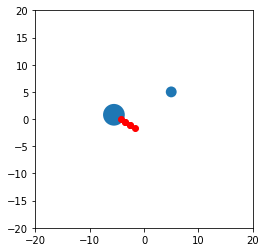

 59%|█████████████████████████▏                 | 1171/2000 [01:40<00:32, 25.84it/s]

episode 1171, the reward is 20000
episode 1172, the reward is 20000
episode 1173, the reward is 20000
episode 1174, the reward is 20000


 59%|█████████████████████████▎                 | 1178/2000 [01:40<00:24, 33.18it/s]

episode 1175, the reward is 20000
episode 1176, the reward is 20000
episode 1177, the reward is 20000
episode 1178, the reward is 20000
episode 1179, the reward is 20000
episode 1180, the reward is 20000


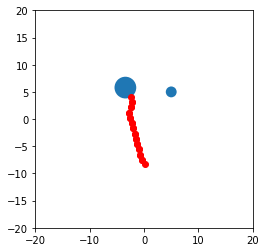

 59%|█████████████████████████▍                 | 1183/2000 [01:40<00:23, 34.41it/s]

episode 1181, the reward is 20000
episode 1182, the reward is 20000
episode 1183, the reward is 20000
episode 1184, the reward is 20000
episode 1185, the reward is 20000
episode 1186, the reward is 20000
episode 1187, the reward is 20000
episode 1188, the reward is 20000
episode 1189, the reward is 20000
episode 1190, the reward is 20000


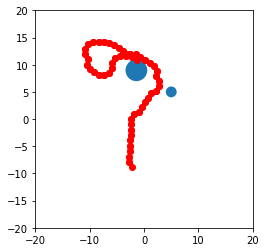

 60%|█████████████████████████▌                 | 1191/2000 [01:40<00:21, 36.83it/s]

episode 1191, the reward is 20000
episode 1192, the reward is 20000
episode 1193, the reward is 20000
episode 1194, the reward is 20000
episode 1195, the reward is 20000
episode 1196, the reward is 20000
episode 1197, the reward is 20000
episode 1198, the reward is 20000
episode 1199, the reward is 20000
episode 1200, the reward is 20000


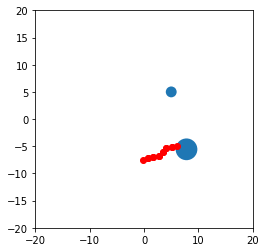

 60%|█████████████████████████▊                 | 1201/2000 [01:40<00:17, 45.26it/s]

episode 1201, the reward is 20000
episode 1202, the reward is 20000
episode 1203, the reward is 20000
episode 1204, the reward is 20000
episode 1205, the reward is 20000
episode 1206, the reward is 20000
episode 1207, the reward is 20000
episode 1208, the reward is 20000
episode 1209, the reward is 20000
episode 1210, the reward is 20000


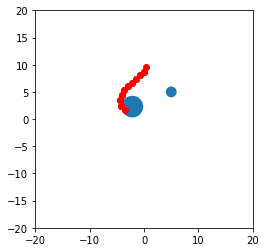

 61%|██████████████████████████                 | 1211/2000 [01:41<00:16, 48.51it/s]

episode 1211, the reward is 20000
episode 1212, the reward is 20000
episode 1213, the reward is 20000
episode 1214, the reward is 20000
episode 1215, the reward is 20000
episode 1216, the reward is 20000
episode 1217, the reward is 20000


 61%|██████████████████████████▏                | 1219/2000 [01:41<00:14, 53.51it/s]

episode 1218, the reward is 20000
episode 1219, the reward is 20000
episode 1220, the reward is 20000


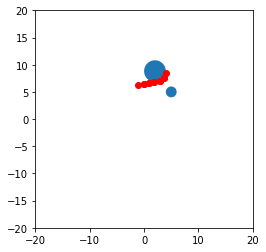

 61%|██████████████████████████▎                | 1225/2000 [01:41<00:14, 53.10it/s]

episode 1221, the reward is 20000
episode 1222, the reward is 20000
episode 1223, the reward is 20000
episode 1224, the reward is 20000
episode 1225, the reward is 20000
episode 1226, the reward is 20000
episode 1227, the reward is 20000
episode 1228, the reward is 20000
episode 1229, the reward is 20000
episode 1230, the reward is 20000


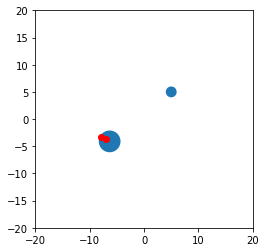

 62%|██████████████████████████▍                | 1231/2000 [01:41<00:16, 45.80it/s]

episode 1231, the reward is 20000
episode 1232, the reward is 20000


 62%|██████████████████████████▌                | 1236/2000 [01:41<00:16, 45.84it/s]

episode 1233, the reward is 20000
episode 1234, the reward is 20000
episode 1235, the reward is 20000
episode 1236, the reward is 20000
episode 1237, the reward is 20000
episode 1238, the reward is 20000
episode 1239, the reward is 20000
episode 1240, the reward is 20000


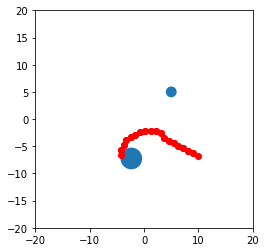

 62%|██████████████████████████▋                | 1241/2000 [01:41<00:20, 37.07it/s]

episode 1241, the reward is 20000
episode 1242, the reward is 20000
episode 1243, the reward is 20000
episode 1244, the reward is 20000
episode 1245, the reward is 20000
episode 1246, the reward is 20000


 62%|██████████████████████████▊                | 1249/2000 [01:41<00:16, 44.95it/s]

episode 1247, the reward is 20000
episode 1248, the reward is 20000
episode 1249, the reward is 20000
episode 1250, the reward is 20000


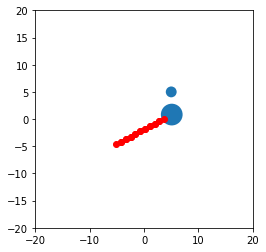

 63%|██████████████████████████▉                | 1254/2000 [01:42<00:17, 43.20it/s]

episode 1251, the reward is 20000
episode 1252, the reward is 20000
episode 1253, the reward is 20000
episode 1254, the reward is 20000
episode 1255, the reward is 20000
episode 1256, the reward is 20000
episode 1257, the reward is 20000
episode 1258, the reward is 20000
episode 1259, the reward is 20000
episode 1260, the reward is 20000


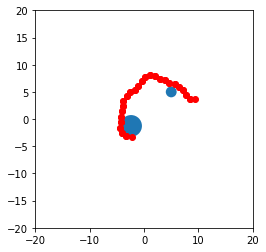

 63%|███████████████████████████                | 1261/2000 [01:42<00:18, 40.38it/s]

episode 1261, the reward is 20000
episode 1262, the reward is 20000
episode 1263, the reward is 20000


 63%|███████████████████████████▏               | 1267/2000 [01:42<00:17, 41.74it/s]

episode 1264, the reward is 20000
episode 1265, the reward is 20000
episode 1266, the reward is 20000
episode 1267, the reward is 20000
episode 1268, the reward is 20000
episode 1269, the reward is 20000
episode 1270, the reward is 20000


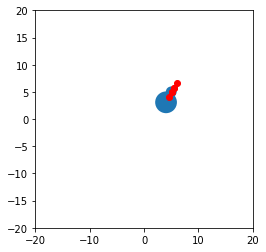

 64%|███████████████████████████▎               | 1272/2000 [01:42<00:18, 38.41it/s]

episode 1271, the reward is 20000
episode 1272, the reward is 20000
episode 1273, the reward is 20000
episode 1274, the reward is 20000
episode 1275, the reward is 20000
episode 1276, the reward is 20000
episode 1277, the reward is 20000
episode 1278, the reward is 20000
episode 1279, the reward is 20000
episode 1280, the reward is 20000


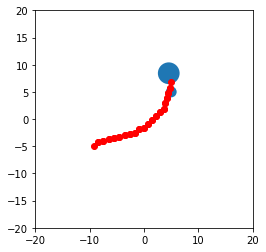

 64%|███████████████████████████▌               | 1281/2000 [01:42<00:16, 42.89it/s]

episode 1281, the reward is 20000
episode 1282, the reward is 20000
episode 1283, the reward is 20000
episode 1284, the reward is 20000
episode 1285, the reward is 20000
episode 1286, the reward is 20000
episode 1287, the reward is 20000
episode 1288, the reward is 20000
episode 1289, the reward is 20000
episode 1290, the reward is 20000


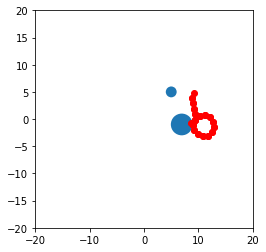

 65%|███████████████████████████▊               | 1291/2000 [01:42<00:15, 46.98it/s]

episode 1291, the reward is 20000


 65%|███████████████████████████▊               | 1296/2000 [01:42<00:14, 47.34it/s]

episode 1292, the reward is 20000
episode 1293, the reward is 20000
episode 1294, the reward is 20000
episode 1295, the reward is 20000
episode 1296, the reward is 20000
episode 1297, the reward is 20000
episode 1298, the reward is 20000
episode 1299, the reward is 20000
episode 1300, the reward is 20000


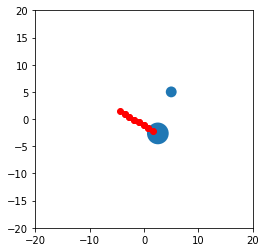

 65%|████████████████████████████▏              | 1309/2000 [01:43<00:13, 52.44it/s]

episode 1301, the reward is 20000
episode 1302, the reward is 20000
episode 1303, the reward is 20000
episode 1304, the reward is 20000
episode 1305, the reward is 20000
episode 1306, the reward is 20000
episode 1307, the reward is 20000
episode 1308, the reward is 20000
episode 1309, the reward is 20000
episode 1310, the reward is 20000


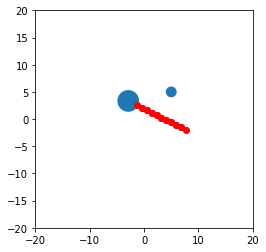

 66%|████████████████████████████▎              | 1315/2000 [01:43<00:13, 50.60it/s]

episode 1311, the reward is 20000
episode 1312, the reward is 20000
episode 1313, the reward is 20000
episode 1314, the reward is 20000
episode 1315, the reward is 20000
episode 1316, the reward is 20000
episode 1317, the reward is 20000
episode 1318, the reward is 20000
episode 1319, the reward is 20000
episode 1320, the reward is 20000


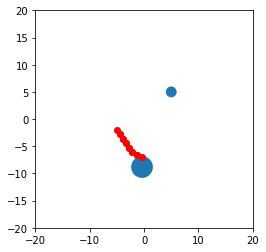

 66%|████████████████████████████▌              | 1326/2000 [01:43<00:14, 45.44it/s]

episode 1321, the reward is 20000
episode 1322, the reward is 20000
episode 1323, the reward is 20000
episode 1324, the reward is 20000
episode 1325, the reward is 20000
episode 1326, the reward is 20000
episode 1327, the reward is 20000
episode 1328, the reward is 20000
episode 1329, the reward is 20000
episode 1330, the reward is 20000


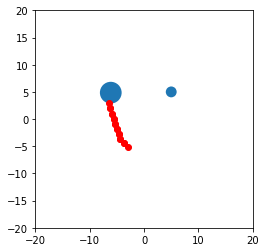

 67%|████████████████████████████▌              | 1331/2000 [01:43<00:14, 45.37it/s]

episode 1331, the reward is 20000
episode 1332, the reward is 20000
episode 1333, the reward is 20000


 67%|████████████████████████████▊              | 1338/2000 [01:43<00:12, 51.03it/s]

episode 1334, the reward is 20000
episode 1335, the reward is 20000
episode 1336, the reward is 20000
episode 1337, the reward is 20000
episode 1338, the reward is 20000
episode 1339, the reward is 20000
episode 1340, the reward is 20000


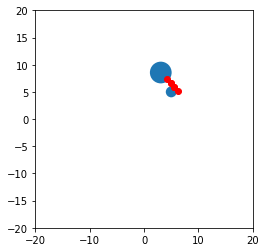

 67%|████████████████████████████▉              | 1344/2000 [01:43<00:13, 48.45it/s]

episode 1341, the reward is 20000
episode 1342, the reward is 20000
episode 1343, the reward is 20000
episode 1344, the reward is 20000
episode 1345, the reward is 20000
episode 1346, the reward is 20000
episode 1347, the reward is 20000
episode 1348, the reward is 20000
episode 1349, the reward is 20000
episode 1350, the reward is 20000


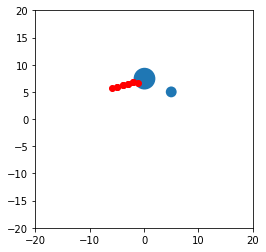

 68%|█████████████████████████████              | 1351/2000 [01:44<00:14, 43.74it/s]

episode 1351, the reward is 20000
episode 1352, the reward is 20000
episode 1353, the reward is 20000
episode 1354, the reward is 20000
episode 1355, the reward is 20000
episode 1356, the reward is 20000
episode 1357, the reward is 20000
episode 1358, the reward is 20000
episode 1359, the reward is 20000
episode 1360, the reward is 20000


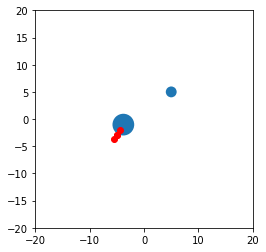

 68%|█████████████████████████████▎             | 1361/2000 [01:44<00:12, 50.11it/s]

episode 1361, the reward is 20000


 68%|█████████████████████████████▍             | 1368/2000 [01:44<00:11, 52.94it/s]

episode 1362, the reward is 20000
episode 1363, the reward is 20000
episode 1364, the reward is 20000
episode 1365, the reward is 20000
episode 1366, the reward is 20000
episode 1367, the reward is 20000
episode 1368, the reward is 20000
episode 1369, the reward is 20000
episode 1370, the reward is 20000


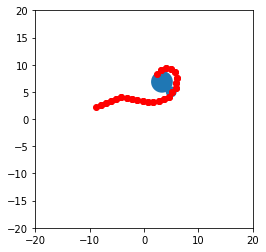

episode 1371, the reward is 20000


 69%|█████████████████████████████▌             | 1374/2000 [01:44<00:13, 47.17it/s]

episode 1372, the reward is 20000
episode 1373, the reward is 20000
episode 1374, the reward is 20000
episode 1375, the reward is 20000
episode 1376, the reward is 20000
episode 1377, the reward is 20000
episode 1378, the reward is 20000
episode 1379, the reward is 20000
episode 1380, the reward is 20000


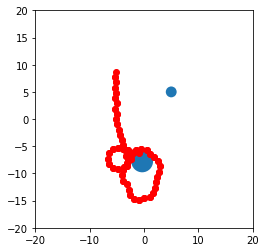

 69%|█████████████████████████████▋             | 1381/2000 [01:44<00:14, 42.10it/s]

episode 1381, the reward is 20000
episode 1382, the reward is 20000
episode 1383, the reward is 20000
episode 1384, the reward is 20000
episode 1385, the reward is 20000
episode 1386, the reward is 20000
episode 1387, the reward is 20000
episode 1388, the reward is 20000
episode 1389, the reward is 20000
episode 1390, the reward is 20000


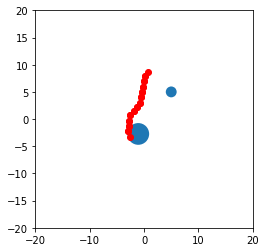

 70%|█████████████████████████████▉             | 1391/2000 [01:44<00:13, 45.63it/s]

episode 1391, the reward is 20000


 70%|██████████████████████████████             | 1396/2000 [01:45<00:13, 44.32it/s]

episode 1392, the reward is 20000
episode 1393, the reward is 20000
episode 1394, the reward is 20000
episode 1395, the reward is 20000
episode 1396, the reward is 20000
episode 1397, the reward is 20000
episode 1398, the reward is 20000
episode 1399, the reward is 20000
episode 1400, the reward is 20000


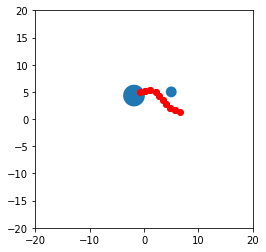

 70%|██████████████████████████████▎            | 1408/2000 [01:45<00:12, 46.00it/s]

episode 1401, the reward is 20000
episode 1402, the reward is 20000
episode 1403, the reward is 20000
episode 1404, the reward is 20000
episode 1405, the reward is 20000
episode 1406, the reward is 20000
episode 1407, the reward is 20000
episode 1408, the reward is 20000
episode 1409, the reward is 20000
episode 1410, the reward is 20000


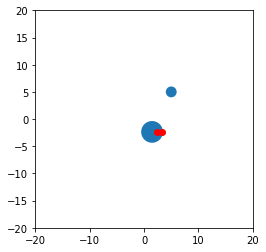

 71%|██████████████████████████████▍            | 1414/2000 [01:45<00:12, 48.48it/s]

episode 1411, the reward is 20000
episode 1412, the reward is 20000
episode 1413, the reward is 20000
episode 1414, the reward is 20000
episode 1415, the reward is 20000
episode 1416, the reward is 20000
episode 1417, the reward is 20000
episode 1418, the reward is 20000
episode 1419, the reward is 20000
episode 1420, the reward is 20000


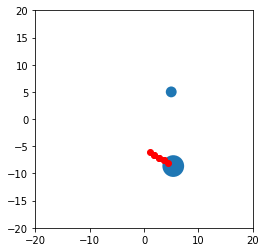

 71%|██████████████████████████████▌            | 1421/2000 [01:45<00:11, 49.21it/s]

episode 1421, the reward is 20000


 71%|██████████████████████████████▋            | 1429/2000 [01:45<00:10, 56.04it/s]

episode 1422, the reward is 20000
episode 1423, the reward is 20000
episode 1424, the reward is 20000
episode 1425, the reward is 20000
episode 1426, the reward is 20000
episode 1427, the reward is 20000
episode 1428, the reward is 20000
episode 1429, the reward is 20000
episode 1430, the reward is 20000


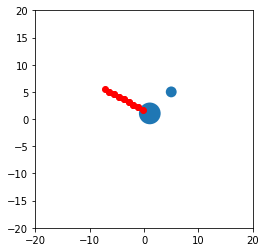

episode 1431, the reward is 20000
episode 1432, the reward is 20000
episode 1433, the reward is 20000


 72%|██████████████████████████████▊            | 1435/2000 [01:45<00:10, 54.06it/s]

episode 1434, the reward is 20000
episode 1435, the reward is 20000
episode 1436, the reward is 20000
episode 1437, the reward is 20000
episode 1438, the reward is 20000
episode 1439, the reward is 20000
episode 1440, the reward is 20000


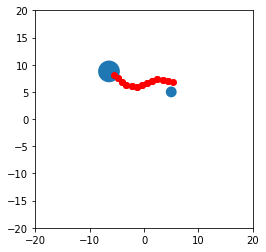

 72%|██████████████████████████████▉            | 1441/2000 [01:45<00:11, 49.53it/s]

episode 1441, the reward is 20000
episode 1442, the reward is 20000
episode 1443, the reward is 20000
episode 1444, the reward is 20000
episode 1445, the reward is 20000


 72%|███████████████████████████████▏           | 1449/2000 [01:46<00:09, 56.94it/s]

episode 1446, the reward is 20000
episode 1447, the reward is 20000
episode 1448, the reward is 20000
episode 1449, the reward is 20000
episode 1450, the reward is 20000


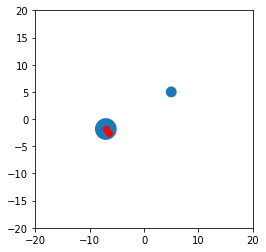

episode 1451, the reward is 20000
episode 1452, the reward is 20000
episode 1453, the reward is 20000


 73%|███████████████████████████████▎           | 1455/2000 [01:46<00:10, 50.67it/s]

episode 1454, the reward is 20000
episode 1455, the reward is 20000
episode 1456, the reward is 20000
episode 1457, the reward is 20000
episode 1458, the reward is 20000
episode 1459, the reward is 20000
episode 1460, the reward is 20000


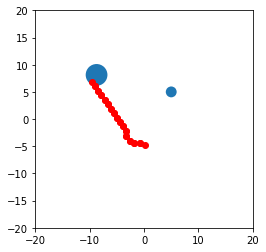

 73%|███████████████████████████████▍           | 1461/2000 [01:46<00:12, 42.14it/s]

episode 1461, the reward is 20000
episode 1462, the reward is 20000
episode 1463, the reward is 20000
episode 1464, the reward is 20000
episode 1465, the reward is 20000
episode 1466, the reward is 20000
episode 1467, the reward is 20000
episode 1468, the reward is 20000
episode 1469, the reward is 20000
episode 1470, the reward is 20000


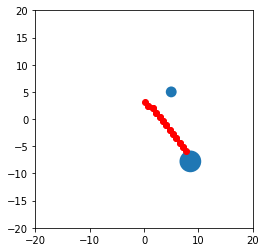

 74%|███████████████████████████████▋           | 1471/2000 [01:46<00:11, 48.01it/s]

episode 1471, the reward is 20000
episode 1472, the reward is 20000
episode 1473, the reward is 20000
episode 1474, the reward is 20000
episode 1475, the reward is 20000
episode 1476, the reward is 20000
episode 1477, the reward is 20000
episode 1478, the reward is 20000
episode 1479, the reward is 20000
episode 1480, the reward is 20000


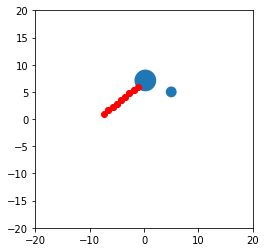

 74%|███████████████████████████████▊           | 1481/2000 [01:46<00:10, 50.82it/s]

episode 1481, the reward is 20000
episode 1482, the reward is 20000
episode 1483, the reward is 20000
episode 1484, the reward is 20000
episode 1485, the reward is 20000
episode 1486, the reward is 20000
episode 1487, the reward is 20000
episode 1488, the reward is 20000
episode 1489, the reward is 20000
episode 1490, the reward is 20000


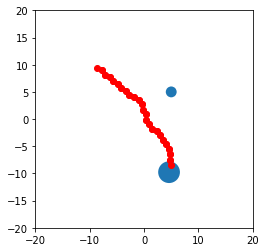

 75%|████████████████████████████████           | 1491/2000 [01:46<00:10, 50.41it/s]

episode 1491, the reward is 20000
episode 1492, the reward is 20000
episode 1493, the reward is 20000
episode 1494, the reward is 20000
episode 1495, the reward is 20000
episode 1496, the reward is 20000
episode 1497, the reward is 20000
episode 1498, the reward is 20000
episode 1499, the reward is 20000
episode 1500, the reward is 20000


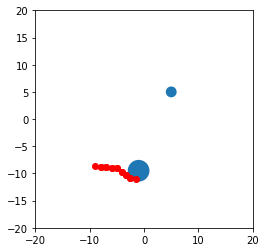

 75%|████████████████████████████████▎          | 1501/2000 [01:47<00:09, 53.21it/s]

episode 1501, the reward is 20000
episode 1502, the reward is 20000
episode 1503, the reward is 20000
episode 1504, the reward is 20000
episode 1505, the reward is 20000
episode 1506, the reward is 20000
episode 1507, the reward is 20000
episode 1508, the reward is 20000
episode 1509, the reward is 20000
episode 1510, the reward is 20000


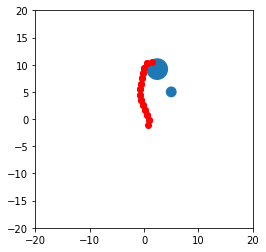

 76%|████████████████████████████████▍          | 1511/2000 [01:47<00:08, 55.12it/s]

episode 1511, the reward is 20000
episode 1512, the reward is 20000
episode 1513, the reward is 20000
episode 1514, the reward is 20000
episode 1515, the reward is 20000
episode 1516, the reward is 20000
episode 1517, the reward is 20000
episode 1518, the reward is 20000
episode 1519, the reward is 20000
episode 1520, the reward is 20000


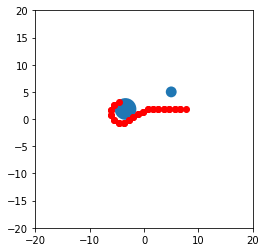

 76%|████████████████████████████████▋          | 1521/2000 [01:47<00:08, 57.07it/s]

episode 1521, the reward is 20000
episode 1522, the reward is 20000
episode 1523, the reward is 20000
episode 1524, the reward is 20000
episode 1525, the reward is 20000
episode 1526, the reward is 20000
episode 1527, the reward is 20000
episode 1528, the reward is 20000
episode 1529, the reward is 20000
episode 1530, the reward is 20000


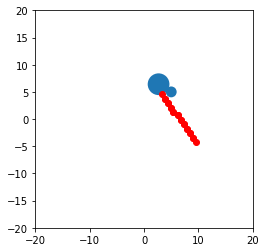

 77%|████████████████████████████████▉          | 1531/2000 [01:47<00:08, 56.74it/s]

episode 1531, the reward is 20000
episode 1532, the reward is 20000
episode 1533, the reward is 20000
episode 1534, the reward is 20000
episode 1535, the reward is 20000
episode 1536, the reward is 20000
episode 1537, the reward is 20000
episode 1538, the reward is 20000
episode 1539, the reward is 20000
episode 1540, the reward is 20000


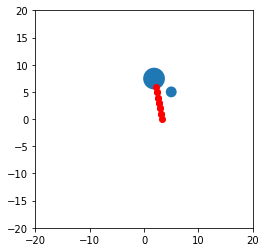

 77%|█████████████████████████████████▏         | 1541/2000 [01:47<00:07, 59.38it/s]

episode 1541, the reward is 20000
episode 1542, the reward is 20000
episode 1543, the reward is 20000
episode 1544, the reward is 20000
episode 1545, the reward is 20000


 77%|█████████████████████████████████▎         | 1548/2000 [01:47<00:07, 60.61it/s]

episode 1546, the reward is 20000
episode 1547, the reward is 20000
episode 1548, the reward is 20000
episode 1549, the reward is 20000
episode 1550, the reward is 20000


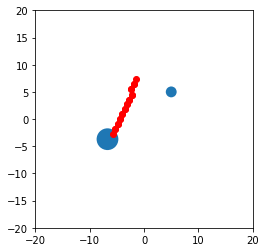

 78%|█████████████████████████████████▍         | 1555/2000 [01:48<00:07, 57.12it/s]

episode 1551, the reward is 20000
episode 1552, the reward is 20000
episode 1553, the reward is 20000
episode 1554, the reward is 20000
episode 1555, the reward is 20000
episode 1556, the reward is 20000
episode 1557, the reward is 20000
episode 1558, the reward is 20000
episode 1559, the reward is 20000
episode 1560, the reward is 20000


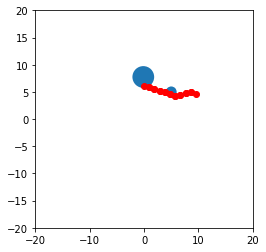

 78%|█████████████████████████████████▌         | 1561/2000 [01:48<00:07, 56.66it/s]

episode 1561, the reward is 20000
episode 1562, the reward is 20000
episode 1563, the reward is 20000
episode 1564, the reward is 20000
episode 1565, the reward is 20000
episode 1566, the reward is 20000
episode 1567, the reward is 20000
episode 1568, the reward is 20000
episode 1569, the reward is 20000
episode 1570, the reward is 20000


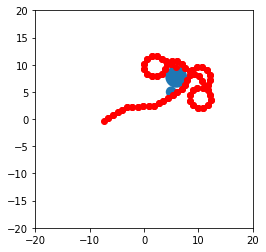

 79%|█████████████████████████████████▊         | 1571/2000 [01:48<00:09, 46.56it/s]

episode 1571, the reward is 20000
episode 1572, the reward is 20000
episode 1573, the reward is 20000
episode 1574, the reward is 20000


 79%|█████████████████████████████████▉         | 1578/2000 [01:48<00:08, 50.32it/s]

episode 1575, the reward is 20000
episode 1576, the reward is 20000
episode 1577, the reward is 20000
episode 1578, the reward is 20000
episode 1579, the reward is 20000
episode 1580, the reward is 20000


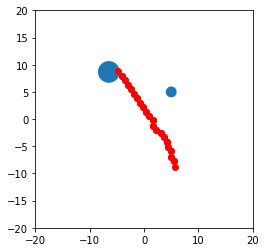

 79%|██████████████████████████████████         | 1584/2000 [01:48<00:09, 45.70it/s]

episode 1581, the reward is 20000
episode 1582, the reward is 20000
episode 1583, the reward is 20000
episode 1584, the reward is 20000
episode 1585, the reward is 20000
episode 1586, the reward is 20000
episode 1587, the reward is 20000
episode 1588, the reward is 20000
episode 1589, the reward is 20000
episode 1590, the reward is 20000


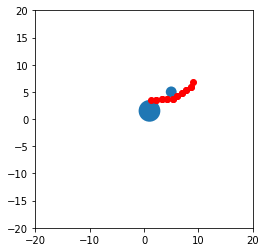

 80%|██████████████████████████████████▏        | 1591/2000 [01:48<00:09, 44.09it/s]

episode 1591, the reward is 20000


 80%|██████████████████████████████████▎        | 1596/2000 [01:49<00:09, 42.61it/s]

episode 1592, the reward is 20000
episode 1593, the reward is 20000
episode 1594, the reward is 20000
episode 1595, the reward is 20000
episode 1596, the reward is 20000
episode 1597, the reward is 20000
episode 1598, the reward is 20000
episode 1599, the reward is 20000
episode 1600, the reward is 20000


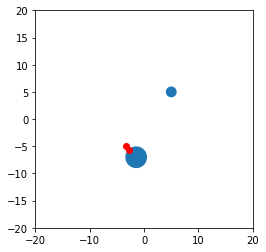

 80%|██████████████████████████████████▍        | 1601/2000 [01:49<00:10, 39.38it/s]

episode 1601, the reward is 20000
episode 1602, the reward is 20000
episode 1603, the reward is 20000
episode 1604, the reward is 20000
episode 1605, the reward is 20000
episode 1606, the reward is 20000


 80%|██████████████████████████████████▌        | 1608/2000 [01:49<00:08, 45.64it/s]

episode 1607, the reward is 20000
episode 1608, the reward is 20000
episode 1609, the reward is 20000
episode 1610, the reward is 20000


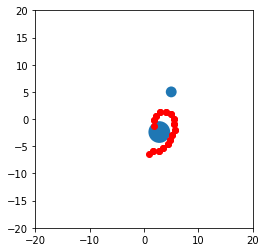

 81%|██████████████████████████████████▋        | 1613/2000 [01:49<00:08, 43.53it/s]

episode 1611, the reward is 20000
episode 1612, the reward is 20000
episode 1613, the reward is 20000
episode 1614, the reward is 20000
episode 1615, the reward is 20000
episode 1616, the reward is 20000
episode 1617, the reward is 20000
episode 1618, the reward is 20000
episode 1619, the reward is 20000
episode 1620, the reward is 20000


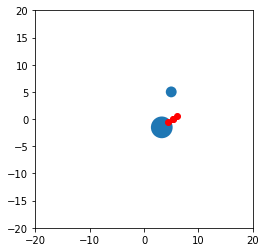

 81%|██████████████████████████████████▊        | 1621/2000 [01:49<00:08, 46.31it/s]

episode 1621, the reward is 20000
episode 1622, the reward is 20000
episode 1623, the reward is 20000
episode 1624, the reward is 20000
episode 1625, the reward is 20000
episode 1626, the reward is 20000


 81%|███████████████████████████████████        | 1628/2000 [01:49<00:07, 51.60it/s]

episode 1627, the reward is 20000
episode 1628, the reward is 20000
episode 1629, the reward is 20000
episode 1630, the reward is 20000


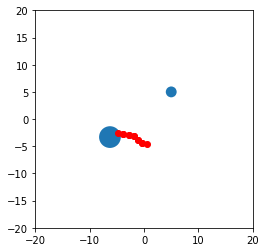

episode 1631, the reward is 20000
episode 1632, the reward is 20000


 82%|███████████████████████████████████▏       | 1634/2000 [01:49<00:07, 49.32it/s]

episode 1633, the reward is 20000
episode 1634, the reward is 20000
episode 1635, the reward is 20000
episode 1636, the reward is 20000
episode 1637, the reward is 20000
episode 1638, the reward is 20000
episode 1639, the reward is 20000
episode 1640, the reward is 20000


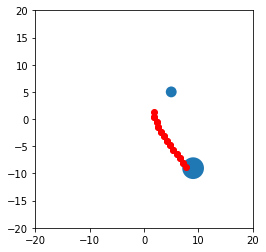

 82%|███████████████████████████████████▎       | 1641/2000 [01:49<00:08, 44.33it/s]

episode 1641, the reward is 20000
episode 1642, the reward is 20000
episode 1643, the reward is 20000
episode 1644, the reward is 20000
episode 1645, the reward is 20000
episode 1646, the reward is 20000
episode 1647, the reward is 20000
episode 1648, the reward is 20000
episode 1649, the reward is 20000
episode 1650, the reward is 20000


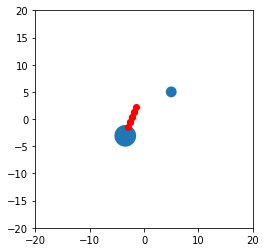

 83%|███████████████████████████████████▍       | 1651/2000 [01:50<00:07, 49.11it/s]

episode 1651, the reward is 20000
episode 1652, the reward is 20000
episode 1653, the reward is 20000
episode 1654, the reward is 20000
episode 1655, the reward is 20000
episode 1656, the reward is 20000
episode 1657, the reward is 20000
episode 1658, the reward is 20000
episode 1659, the reward is 20000
episode 1660, the reward is 20000


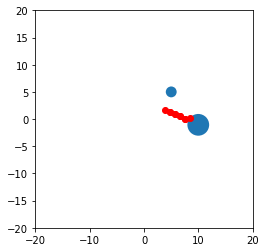

 83%|███████████████████████████████████▋       | 1661/2000 [01:50<00:06, 51.10it/s]

episode 1661, the reward is 20000
episode 1662, the reward is 20000
episode 1663, the reward is 20000
episode 1664, the reward is 20000
episode 1665, the reward is 20000
episode 1666, the reward is 20000
episode 1667, the reward is 20000
episode 1668, the reward is 20000
episode 1669, the reward is 20000
episode 1670, the reward is 20000


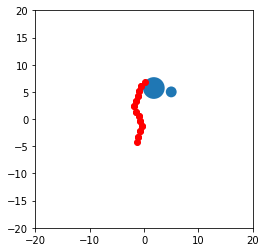

 84%|███████████████████████████████████▉       | 1671/2000 [01:50<00:05, 56.17it/s]

episode 1671, the reward is 20000
episode 1672, the reward is 20000
episode 1673, the reward is 20000
episode 1674, the reward is 20000
episode 1675, the reward is 20000
episode 1676, the reward is 20000
episode 1677, the reward is 20000
episode 1678, the reward is 20000
episode 1679, the reward is 20000
episode 1680, the reward is 20000


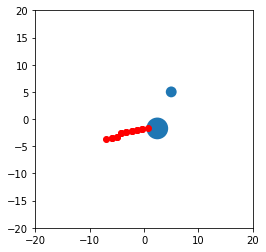

 84%|████████████████████████████████████▏      | 1681/2000 [01:50<00:05, 55.21it/s]

episode 1681, the reward is 20000
episode 1682, the reward is 20000
episode 1683, the reward is 20000
episode 1684, the reward is 20000
episode 1685, the reward is 20000
episode 1686, the reward is 20000
episode 1687, the reward is 20000
episode 1688, the reward is 20000
episode 1689, the reward is 20000
episode 1690, the reward is 20000


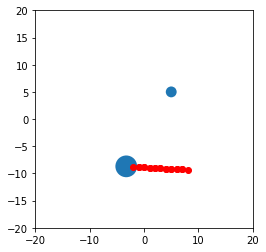

 85%|████████████████████████████████████▎      | 1691/2000 [01:50<00:05, 57.59it/s]

episode 1691, the reward is 20000
episode 1692, the reward is 20000
episode 1693, the reward is 20000
episode 1694, the reward is 20000
episode 1695, the reward is 20000
episode 1696, the reward is 20000
episode 1697, the reward is 20000
episode 1698, the reward is 20000
episode 1699, the reward is 20000
episode 1700, the reward is 20000


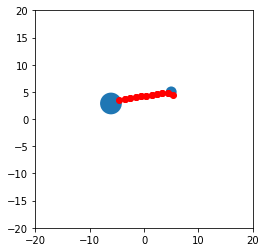

 85%|████████████████████████████████████▌      | 1701/2000 [01:51<00:05, 57.91it/s]

episode 1701, the reward is 20000
episode 1702, the reward is 20000
episode 1703, the reward is 20000
episode 1704, the reward is 20000
episode 1705, the reward is 20000
episode 1706, the reward is 20000
episode 1707, the reward is 20000
episode 1708, the reward is 20000
episode 1709, the reward is 20000
episode 1710, the reward is 20000


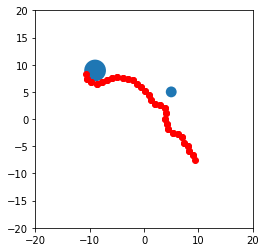

 86%|████████████████████████████████████▊      | 1711/2000 [01:51<00:05, 55.17it/s]

episode 1711, the reward is 20000
episode 1712, the reward is 20000
episode 1713, the reward is 20000
episode 1714, the reward is 20000
episode 1715, the reward is 20000
episode 1716, the reward is 20000
episode 1717, the reward is 20000
episode 1718, the reward is 20000
episode 1719, the reward is 20000
episode 1720, the reward is 20000


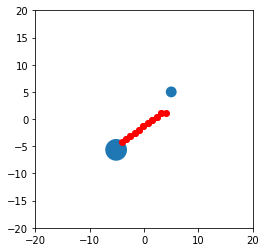

 86%|█████████████████████████████████████      | 1721/2000 [01:51<00:05, 54.96it/s]

episode 1721, the reward is 20000
episode 1722, the reward is 20000
episode 1723, the reward is 20000
episode 1724, the reward is 20000
episode 1725, the reward is 20000
episode 1726, the reward is 20000
episode 1727, the reward is 20000
episode 1728, the reward is 20000
episode 1729, the reward is 20000
episode 1730, the reward is 20000


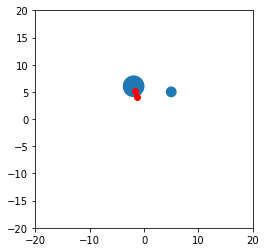

 87%|█████████████████████████████████████▏     | 1731/2000 [01:51<00:04, 56.51it/s]

episode 1731, the reward is 20000
episode 1732, the reward is 20000
episode 1733, the reward is 20000
episode 1734, the reward is 20000
episode 1735, the reward is 20000


 87%|█████████████████████████████████████▍     | 1739/2000 [01:51<00:04, 59.76it/s]

episode 1736, the reward is 20000
episode 1737, the reward is 20000
episode 1738, the reward is 20000
episode 1739, the reward is 20000
episode 1740, the reward is 20000


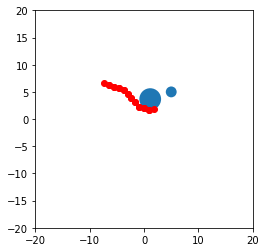

episode 1741, the reward is 20000


 87%|█████████████████████████████████████▌     | 1746/2000 [01:51<00:04, 58.84it/s]

episode 1742, the reward is 20000
episode 1743, the reward is 20000
episode 1744, the reward is 20000
episode 1745, the reward is 20000
episode 1746, the reward is 20000
episode 1747, the reward is 20000
episode 1748, the reward is 20000
episode 1749, the reward is 20000
episode 1750, the reward is 20000


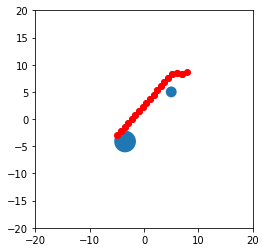

 88%|█████████████████████████████████████▋     | 1752/2000 [01:51<00:04, 54.24it/s]

episode 1751, the reward is 20000
episode 1752, the reward is 20000
episode 1753, the reward is 20000
episode 1754, the reward is 20000
episode 1755, the reward is 20000
episode 1756, the reward is 20000
episode 1757, the reward is 20000
episode 1758, the reward is 20000
episode 1759, the reward is 20000
episode 1760, the reward is 20000


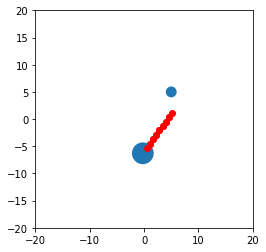

 88%|█████████████████████████████████████▊     | 1761/2000 [01:52<00:04, 54.28it/s]

episode 1761, the reward is 20000
episode 1762, the reward is 20000
episode 1763, the reward is 20000
episode 1764, the reward is 20000
episode 1765, the reward is 20000
episode 1766, the reward is 20000
episode 1767, the reward is 20000
episode 1768, the reward is 20000
episode 1769, the reward is 20000
episode 1770, the reward is 20000


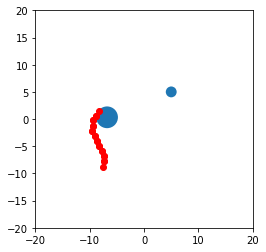

 89%|██████████████████████████████████████     | 1771/2000 [01:52<00:04, 55.91it/s]

episode 1771, the reward is 20000
episode 1772, the reward is 20000
episode 1773, the reward is 20000
episode 1774, the reward is 20000
episode 1775, the reward is 20000
episode 1776, the reward is 20000
episode 1777, the reward is 20000
episode 1778, the reward is 20000
episode 1779, the reward is 20000
episode 1780, the reward is 20000


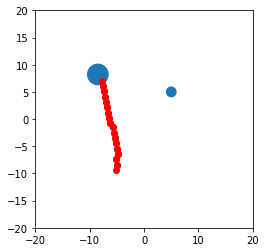

 89%|██████████████████████████████████████▎    | 1781/2000 [01:52<00:04, 54.16it/s]

episode 1781, the reward is 20000
episode 1782, the reward is 20000
episode 1783, the reward is 20000
episode 1784, the reward is 20000
episode 1785, the reward is 20000
episode 1786, the reward is 20000
episode 1787, the reward is 20000
episode 1788, the reward is 20000
episode 1789, the reward is 20000
episode 1790, the reward is 20000


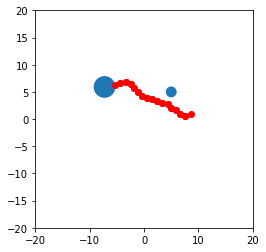

 90%|██████████████████████████████████████▌    | 1791/2000 [01:52<00:04, 51.93it/s]

episode 1791, the reward is 20000


 90%|██████████████████████████████████████▋    | 1797/2000 [01:52<00:03, 51.25it/s]

episode 1792, the reward is 20000
episode 1793, the reward is 20000
episode 1794, the reward is 20000
episode 1795, the reward is 20000
episode 1796, the reward is 20000
episode 1797, the reward is 20000
episode 1798, the reward is 20000
episode 1799, the reward is 20000
episode 1800, the reward is 20000


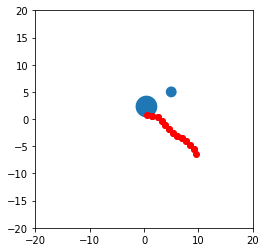

 90%|██████████████████████████████████████▊    | 1803/2000 [01:52<00:03, 49.50it/s]

episode 1801, the reward is 20000
episode 1802, the reward is 20000
episode 1803, the reward is 20000
episode 1804, the reward is 20000
episode 1805, the reward is 20000
episode 1806, the reward is 20000
episode 1807, the reward is 20000
episode 1808, the reward is 20000
episode 1809, the reward is 20000
episode 1810, the reward is 20000


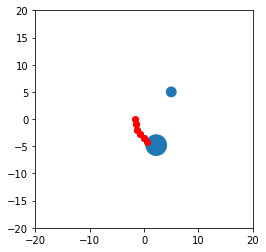

 91%|██████████████████████████████████████▉    | 1811/2000 [01:53<00:03, 50.47it/s]

episode 1811, the reward is 20000
episode 1812, the reward is 20000
episode 1813, the reward is 20000
episode 1814, the reward is 20000
episode 1815, the reward is 20000
episode 1816, the reward is 20000
episode 1817, the reward is 20000
episode 1818, the reward is 20000
episode 1819, the reward is 20000
episode 1820, the reward is 20000


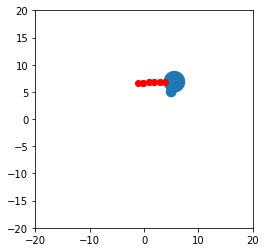

 91%|███████████████████████████████████████▏   | 1821/2000 [01:53<00:03, 55.40it/s]

episode 1821, the reward is 20000
episode 1822, the reward is 20000
episode 1823, the reward is 20000
episode 1824, the reward is 20000
episode 1825, the reward is 20000
episode 1826, the reward is 20000
episode 1827, the reward is 20000


 92%|███████████████████████████████████████▎   | 1830/2000 [01:53<00:02, 62.62it/s]

episode 1828, the reward is 20000
episode 1829, the reward is 20000
episode 1830, the reward is 20000


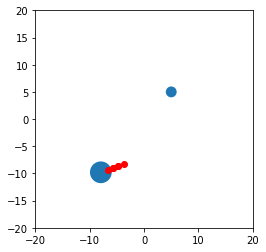

episode 1831, the reward is 20000
episode 1832, the reward is 20000
episode 1833, the reward is 20000


 92%|███████████████████████████████████████▍   | 1837/2000 [01:53<00:02, 56.86it/s]

episode 1834, the reward is 20000
episode 1835, the reward is 20000
episode 1836, the reward is 20000
episode 1837, the reward is 20000
episode 1838, the reward is 20000
episode 1839, the reward is 20000
episode 1840, the reward is 20000


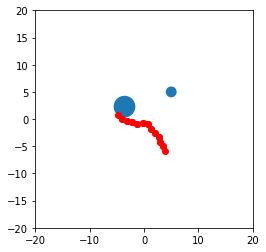

 92%|███████████████████████████████████████▌   | 1843/2000 [01:53<00:02, 52.76it/s]

episode 1841, the reward is 20000
episode 1842, the reward is 20000
episode 1843, the reward is 20000
episode 1844, the reward is 20000
episode 1845, the reward is 20000
episode 1846, the reward is 20000
episode 1847, the reward is 20000
episode 1848, the reward is 20000
episode 1849, the reward is 20000
episode 1850, the reward is 20000


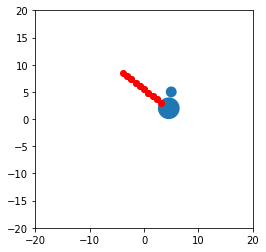

 93%|███████████████████████████████████████▊   | 1851/2000 [01:53<00:02, 53.88it/s]

episode 1851, the reward is 20000
episode 1852, the reward is 20000
episode 1853, the reward is 20000
episode 1854, the reward is 20000
episode 1855, the reward is 20000
episode 1856, the reward is 20000
episode 1857, the reward is 20000
episode 1858, the reward is 20000
episode 1859, the reward is 20000
episode 1860, the reward is 20000


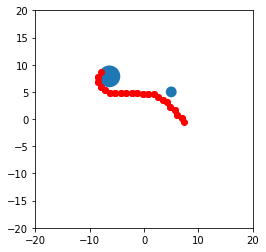

 93%|████████████████████████████████████████   | 1861/2000 [01:53<00:02, 56.16it/s]

episode 1861, the reward is 20000
episode 1862, the reward is 20000
episode 1863, the reward is 20000
episode 1864, the reward is 20000
episode 1865, the reward is 20000
episode 1866, the reward is 20000
episode 1867, the reward is 20000
episode 1868, the reward is 20000
episode 1869, the reward is 20000
episode 1870, the reward is 20000


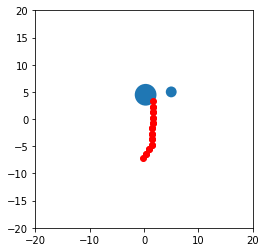

 94%|████████████████████████████████████████▏  | 1871/2000 [01:54<00:02, 58.22it/s]

episode 1871, the reward is 20000
episode 1872, the reward is 20000
episode 1873, the reward is 20000
episode 1874, the reward is 20000
episode 1875, the reward is 20000
episode 1876, the reward is 20000
episode 1877, the reward is 20000


 94%|████████████████████████████████████████▍  | 1879/2000 [01:54<00:03, 34.29it/s]

episode 1878, the reward is -234.139
episode 1879, the reward is 20000
episode 1880, the reward is 20000


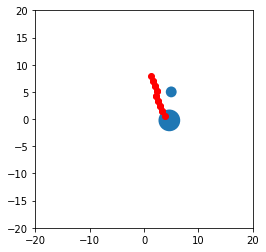

 94%|████████████████████████████████████████▌  | 1884/2000 [01:54<00:03, 35.92it/s]

episode 1881, the reward is 20000
episode 1882, the reward is 20000
episode 1883, the reward is 20000
episode 1884, the reward is 20000
episode 1885, the reward is 20000
episode 1886, the reward is 20000
episode 1887, the reward is 20000
episode 1888, the reward is 20000
episode 1889, the reward is 20000
episode 1890, the reward is 20000


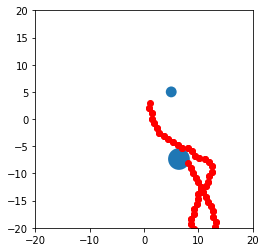

 95%|████████████████████████████████████████▊  | 1898/2000 [01:55<00:03, 25.82it/s]

episode 1891, the reward is 20000
episode 1892, the reward is 20000
episode 1893, the reward is 20000
episode 1894, the reward is 20000
episode 1895, the reward is 20000
episode 1896, the reward is 20000
episode 1897, the reward is 20000
episode 1898, the reward is 20000
episode 1899, the reward is -272.847
episode 1900, the reward is 20000


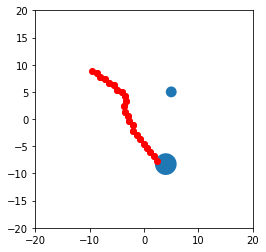

 95%|████████████████████████████████████████▉  | 1903/2000 [01:56<00:05, 17.02it/s]

episode 1901, the reward is 20000
episode 1902, the reward is 20000
episode 1903, the reward is 20000
episode 1904, the reward is 20000
episode 1905, the reward is 20000
episode 1906, the reward is 20000
episode 1907, the reward is 20000
episode 1908, the reward is 20000
episode 1909, the reward is 20000
episode 1910, the reward is 20000


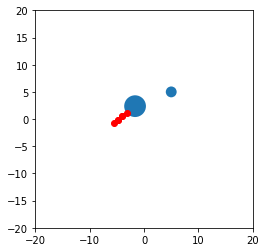

 96%|█████████████████████████████████████████  | 1911/2000 [01:56<00:04, 21.76it/s]

episode 1911, the reward is 20000
episode 1912, the reward is 20000
episode 1913, the reward is 20000
episode 1914, the reward is 20000
episode 1915, the reward is 20000


 96%|█████████████████████████████████████████▎ | 1919/2000 [01:56<00:02, 28.25it/s]

episode 1916, the reward is 20000
episode 1917, the reward is 20000
episode 1918, the reward is 20000
episode 1919, the reward is 20000
episode 1920, the reward is 20000


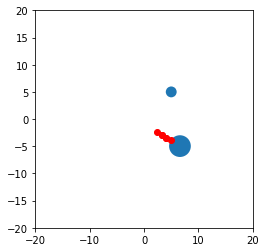

 96%|█████████████████████████████████████████▎ | 1924/2000 [01:56<00:02, 29.01it/s]

episode 1921, the reward is 20000
episode 1922, the reward is 20000
episode 1923, the reward is 20000
episode 1924, the reward is 20000
episode 1925, the reward is 20000
episode 1926, the reward is 20000
episode 1927, the reward is 20000
episode 1928, the reward is 20000
episode 1929, the reward is 20000
episode 1930, the reward is 20000


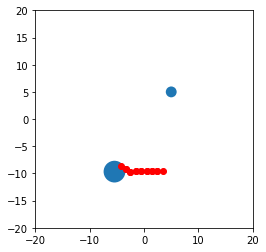

 97%|█████████████████████████████████████████▌ | 1931/2000 [01:56<00:02, 32.62it/s]

episode 1931, the reward is 20000
episode 1932, the reward is 20000
episode 1933, the reward is 20000
episode 1934, the reward is 20000
episode 1935, the reward is 20000
episode 1936, the reward is 20000
episode 1937, the reward is 20000
episode 1938, the reward is 20000
episode 1939, the reward is 20000
episode 1940, the reward is 20000


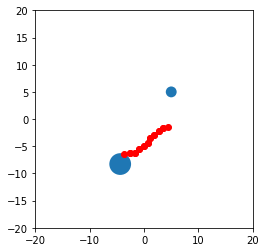

 97%|█████████████████████████████████████████▋ | 1941/2000 [01:56<00:01, 37.64it/s]

episode 1941, the reward is 20000
episode 1942, the reward is 20000
episode 1943, the reward is 20000
episode 1944, the reward is 20000


 98%|█████████████████████████████████████████▉ | 1950/2000 [01:57<00:01, 46.56it/s]

episode 1945, the reward is 20000
episode 1946, the reward is 20000
episode 1947, the reward is 20000
episode 1948, the reward is 20000
episode 1949, the reward is 20000
episode 1950, the reward is 20000


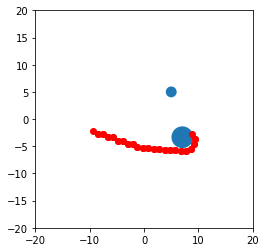

episode 1951, the reward is 20000


 98%|██████████████████████████████████████████ | 1956/2000 [01:57<00:01, 42.10it/s]

episode 1952, the reward is 20000
episode 1953, the reward is 20000
episode 1954, the reward is 20000
episode 1955, the reward is 20000
episode 1956, the reward is 20000
episode 1957, the reward is 20000
episode 1958, the reward is 20000
episode 1959, the reward is 20000
episode 1960, the reward is 20000


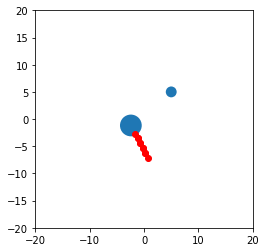

 98%|██████████████████████████████████████████▏| 1962/2000 [01:57<00:00, 42.32it/s]

episode 1961, the reward is 20000
episode 1962, the reward is 20000
episode 1963, the reward is 20000
episode 1964, the reward is 20000
episode 1965, the reward is 20000
episode 1966, the reward is 20000
episode 1967, the reward is 20000
episode 1968, the reward is 20000
episode 1969, the reward is 20000
episode 1970, the reward is 20000


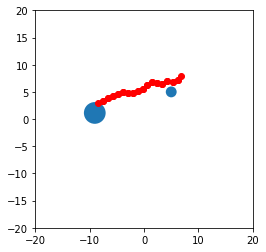

 99%|██████████████████████████████████████████▍| 1971/2000 [01:57<00:00, 43.79it/s]

episode 1971, the reward is 20000
episode 1972, the reward is 20000
episode 1973, the reward is 20000
episode 1974, the reward is 20000
episode 1975, the reward is 20000
episode 1976, the reward is 20000
episode 1977, the reward is 20000
episode 1978, the reward is 20000
episode 1979, the reward is 20000
episode 1980, the reward is 20000


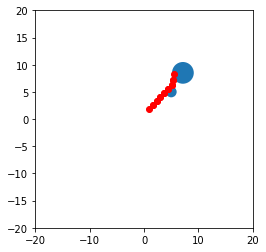

 99%|██████████████████████████████████████████▌| 1981/2000 [01:57<00:00, 44.63it/s]

episode 1981, the reward is 20000
episode 1982, the reward is 20000
episode 1983, the reward is 20000
episode 1984, the reward is 20000
episode 1985, the reward is 20000
episode 1986, the reward is 20000
episode 1987, the reward is 20000
episode 1988, the reward is 20000
episode 1989, the reward is 20000
episode 1990, the reward is 20000


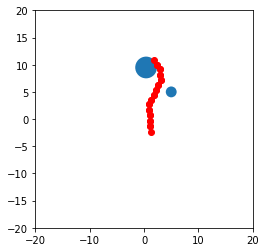

100%|██████████████████████████████████████████▊| 1991/2000 [01:57<00:00, 48.65it/s]

episode 1991, the reward is 20000
episode 1992, the reward is 20000
episode 1993, the reward is 20000
episode 1994, the reward is 20000
episode 1995, the reward is 20000
episode 1996, the reward is 20000
episode 1997, the reward is 20000
episode 1998, the reward is 20000


100%|███████████████████████████████████████████| 2000/2000 [01:58<00:00, 16.88it/s]

episode 1999, the reward is -994.461


In [89]:
rewards = []
net = DQN()

def main():
    print("The DQN is collecting experience...")
    step_counter_list = []
    for episode in tqdm.tqdm(range(EPISODES)):
        state = env.reset()
        step_counter = 0
        sum_rew = 0
        while True:
            step_counter +=1
            action = net.choose_action(state)
            next_state, reward, done = env.step(action)
            # reward = reward * 100 if reward > 0 else reward * 5
            sum_rew += reward
            net.store_trans(state, action, reward, next_state)
            if net.memory_counter >= MEMORY_CAPACITY:
                net.learn()
            if done:
                step_counter_list.append(step_counter)
                print("episode {}, the reward is {}".format(episode, round(reward, 3)))
                rewards.append(sum_rew)
                if episode % 10 == 0:
                    env.draw_map()
                # net.plot(net.ax, step_counter_list)
                break

            state = next_state
            

if __name__ == '__main__':
    main()

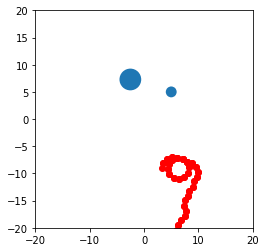

In [90]:
env.draw_map()

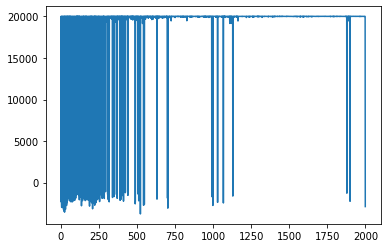

In [91]:
plt.plot(rewards)

In [92]:
m = 0
p = 0
for i in rewards:
    if i < 0:
        m += 1
    else:
        p += 1

In [95]:
m / (m + p)

0.07

In [94]:
p

1860

In [ ]:
class QLearningTable:
    def __init__(self, actions, learning_rate=0.01, reward_decay=0.9, e_greedy=0.9):
        self.actions = actions
        print(self.actions)
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon = e_greedy
        self.q_table = pd.DataFrame(columns=self.actions, dtype=np.float64)
        self.q_table_final = pd.DataFrame(columns=self.actions, dtype=np.float64)

    def choose_action(self, observation):
        self.check_state_exist(observation)
        
        if np.random.uniform() < self.epsilon:
            state_action = self.q_table.loc[observation, :]
            state_action = state_action.reindex(np.random.permutation(state_action.index))
            action = state_action.idxmax()
        else:
            action = np.random.choice(self.actions)
        return action

    def learn(self, state, action, reward, next_state):
        self.check_state_exist(next_state)

        q_predict = self.q_table.loc[state, action]

        if next_state != 'goal' or next_state != 'obstacle':
            q_target = reward + self.gamma * self.q_table.loc[next_state, :].max()
        else:
            q_target = reward
        self.q_table.loc[state, action] += self.lr * (q_target - q_predict)

        return self.q_table.loc[state, action]

    def check_state_exist(self, state):
        if state not in self.q_table.index:
            self.q_table = self.q_table.append(
                pd.Series(
                    [0]*len(self.actions),
                    index=self.q_table.columns,
                    name=state,
                )
            )